## TP 1 

### Librerias

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import random

In [59]:
pd.set_option('display.float_format', '{:.10f}'.format)

### Variables

In [60]:
counter = 1
PROB_CROSSOVER = 0.75
PROB_MUTACION = 0.05
CICLOS = 200
CANTIDAD_POBLACION = 10
COEF = 1073741823 # (2^30) - 1
ITERACIONES_IMPRIMIBLES = [20, 100, 200]

### Fitness y Objetivo

In [61]:
def convertirPoblacion(pob_ini, bin=True): # Pasar False para convertir a decimal
    pob_fin = []
    for numero in pob_ini:
        if bin:
            pob_fin.append(format(numero,'030b'))
        else:
            pob_fin.append(int(str(numero), 2))
    return pob_fin

In [62]:
def funcionObjetivo(poblacion_binarios):
    poblacion = convertirPoblacion(poblacion_binarios, False)
    fun_objetivo = []
    for cromosoma in poblacion:
        fun_objetivo.append((cromosoma/COEF)**2)
    return fun_objetivo

In [63]:
def funcionFitness(poblacion_binarios):
    fitness = []
    fun_objetivo = funcionObjetivo(poblacion_binarios)
    for objetivo in fun_objetivo:
        fitness.append((objetivo/sum(fun_objetivo)))
    return fitness

#### Poblacion

In [64]:
def poblacionInicial(cantidad_cromosomas=CANTIDAD_POBLACION, cantidad_genes=30):
    def generar_cromosoma(cantidad_genes):
        genes = [] 
        for iteracion in range(cantidad_genes):
            gen = random.randrange(start=0, stop=2,step=1)
            genes.append(gen)
        return genes
     
    poblacion = []
    for iteracion in range(0,cantidad_cromosomas):
        cromosoma = generar_cromosoma(cantidad_genes) 
        cadena = ""
        for gen in cromosoma:
            cadena += str(gen) 
        cromosoma = int(cadena,2)
        poblacion.append(cromosoma) 

    return poblacion 
poblacion_decimal = poblacionInicial()
print(poblacion_decimal) 




[800550173, 261975055, 908459298, 754225395, 697566450, 544976980, 837498106, 689365471, 305432471, 486504697]


#### Binarios

In [65]:
poblacion_binarios = convertirPoblacion(poblacionInicial(), True)
#poblacion_binarios

### Tabla de datos

In [66]:
def generarDataFrame(pob_bin):
    pob_dec = convertirPoblacion(pob_bin, False)
    data = {'Decimales': pob_dec, 'Binarios': pob_bin, 
            'FuncionObjetivo':np.array(funcionObjetivo(pob_bin))}
    data_frame = pd.DataFrame(data)
    data_frame['Fitness'] = np.array(funcionFitness(pob_bin))
    return data_frame
data_frame = generarDataFrame(poblacion_binarios)
#data_frame

#### Estadisticas Marco de datos

In [67]:
def generarEstadisticas(dataFrame):
    indice_cromosoma_max = dataFrame[dataFrame['FuncionObjetivo']==dataFrame['FuncionObjetivo'].max()].index.values[0]
    cromosoma_max = dataFrame['Binarios'][indice_cromosoma_max]
    stats = {'Suma':[ dataFrame['FuncionObjetivo'].sum(), dataFrame['Fitness'].sum() ],
                'Promedio': [ dataFrame['FuncionObjetivo'].mean(), dataFrame['Fitness'].mean() ],
                'Máximo': [ dataFrame['FuncionObjetivo'].max(), dataFrame['Fitness'].max() ], 
                'Mínimo': [ dataFrame['FuncionObjetivo'].min(), dataFrame['Fitness'].min() ]}
    dataFrame_stats = pd.DataFrame(stats, index = ['Función objetivo', 'Fitness'])
    return dataFrame_stats, stats, cromosoma_max
marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(data_frame)
marcoDeDatos_stats

,Suma,Promedio,Máximo,Mínimo
Función objetivo,3.1848124115,0.3184812412,0.6925702188,0.0213334535
Fitness,1.0000000000,0.1000000000,0.2174602863,0.0066984961


### Ruleta

In [68]:
def ruleta(pob_bin, cantidad_poblacion):
    # Asigna probabilidad basada en el fitness
    cromosomas = np.array(pob_bin)
    fitness = np.array(funcionFitness(pob_bin))
    np.random.seed()
    binarios_ruleta = []
    # LLENAR RULETA
    arreglo_ruleta = []
    for i in range(0,len(cromosomas)-1):
        posiciones_en_ruleta = fitness[i]*1000 #Habra como mínimo 1000 elementos en la ruleta. Esto es para minimizar el error. 
        for j in range(0,math.ceil(posiciones_en_ruleta)): #math.ceil siempre devolvera un numero mayor a cero en este caso. siempre habrá almenos un elemento.
            arreglo_ruleta.append(cromosomas[i])
    for k in range(0,cantidad_poblacion):
        posicion_ruleta_random = random.randrange(start=0, stop=len(arreglo_ruleta),step=1)
        binarios_ruleta.append(arreglo_ruleta[posicion_ruleta_random])
    return binarios_ruleta
binarios_ruleta = ruleta(poblacion_binarios, 10)
print(binarios_ruleta)
#binarios_ruleta

['101101011000001110000001010010', '100110000100011100101100110000', '110101010000101110010110000000', '100100110011000111101110000010', '101101011000001110000001010010', '110001100110011110111000010100', '101101011000001110000001010010', '100110000100011100101100110000', '010110111011000011011101101101', '110101010000101110010110000000']


### Crossover

In [69]:
def crossover(poblacion_binarios):
    hijos_crossover = []
    pob_binarios = np.array(poblacion_binarios)
    cantidad_poblacion = len(pob_binarios)
    genes = len(pob_binarios[0])
    for i in range(0, cantidad_poblacion-1, 2):
        opciones = [True, False]
        np.random.seed()
        # Probabilidades de cada opción
        prob_cross = np.array([PROB_CROSSOVER, (1-PROB_CROSSOVER)])
        cross = np.random.choice(opciones, size=1, p=prob_cross)
        if cross[0]:
            posiciones = [x for x in range(0, genes)]
            probCorte = [(1/genes) for x in range(0, genes)]
            # Devuelve ndarray de 1 elemento
            corte = np.random.choice(posiciones, size=1, p=probCorte)
            posicionCorte = corte[0]
            
            primerTiraGenesPadre1 = pob_binarios[i][0:posicionCorte]
            segundaTiraGenesPadre1 = pob_binarios[i][posicionCorte:genes]

            primerTiraGenesPadre2 = pob_binarios[i+1][0:posicionCorte]
            segundaTiraGenesPadre2 = pob_binarios[i+1][posicionCorte:genes]
            hijos_crossover.append(primerTiraGenesPadre1 + segundaTiraGenesPadre2)  # Hijo 1
            hijos_crossover.append(primerTiraGenesPadre2 + segundaTiraGenesPadre1)  # Hijo 2
        else:
            hijos_crossover.append(pob_binarios[i])
            hijos_crossover.append(pob_binarios[i+1])
    return hijos_crossover
binarios_crossover = crossover(binarios_ruleta)
#binarios_crossover

### Mutacion

In [70]:
def mutacion(hijos_binarios):
        hijos_mutados = []
        # if len(hijos_binarios) > 0:
        genes = len(str(hijos_binarios[0]))
        for hijo in hijos_binarios:
            opciones = [True, False]
            np.random.seed()
            # Probabilidades de cada opción
            prob_mut = np.array([PROB_MUTACION, (1-PROB_MUTACION)])
            mut = np.random.choice(opciones, size=1, p=prob_mut)
            if mut[0]:
                posiciones = [x for x in range(0, genes)]
                probMutacion = [1/genes for x in range(0, genes)]
                # Devuelve ndarray de 1 elemento
                posicionMutacion = np.random.choice(posiciones, size=1, p=probMutacion)
                posicionMutacion = posicionMutacion[0]
                if hijo[posicionMutacion] == '0':
                    hijo = hijo[:posicionMutacion] + '1' + hijo[posicionMutacion+1:]
                else:
                    hijo = hijo[:posicionMutacion] + '0' + hijo[posicionMutacion+1:]
            hijos_mutados.append(hijo)
        return hijos_mutados
mutados = mutacion(binarios_crossover)
#mutados

### Torneo

In [71]:
def torneo(poblacion_binarios, cantidad_poblacion):
    binarios_torneo = []
    pob_binarios = np.array(poblacion_binarios)
    fitness = np.array(funcionFitness(pob_binarios))
    for i in range(0, cantidad_poblacion):
        posiblesCantidades = [x for x in range(1, (cantidad_poblacion+1))]
        np.random.seed()
        cantidadMiembrosTorneo = np.random.choice(posiblesCantidades, size=1)
        # Trabaja directamente con los fitness de los cromósomas
        miembrosTorneo = np.random.choice(fitness, size=cantidadMiembrosTorneo[0], replace=False)
        ganador = np.amax(miembrosTorneo)
        indiceGanador = np.where(fitness == ganador)  # retorna ndarray
        cromosomaGanador = pob_binarios[indiceGanador[0][0]]
        binarios_torneo.append(cromosomaGanador)
    return binarios_torneo
binarios_torneo = torneo(poblacion_binarios, 10)
binarios_torneo

['110101010000101110010110000000',
 '110001100110011110111000010100',
 '110101010000101110010110000000',
 '110101010000101110010110000000',
 '110101010000101110010110000000',
 '110101010000101110010110000000',
 '010110111011000011011101101101',
 '110101010000101110010110000000',
 '100001000010001001111100001101',
 '101101011000001110000001010010']

### Elitismo

In [72]:
def elitismo(poblacion_binarios, cantidad):
    fitness = funcionFitness(poblacion_binarios)
    elites = []
    for i in range(0, cantidad):
        ganador = max(fitness)
        indiceGanador = fitness.index(ganador)
        cromosomaGanador = poblacion_binarios[indiceGanador]
        elites.append(cromosomaGanador)
        fitness.remove(ganador)
    return elites
elites = elitismo(poblacion_binarios, 2)
elites

['110101010000101110010110000000', '010111100110010001000011100100']

## Iteracion

### Tablas

In [73]:
def hacerTabla(cantIteraciones, cromosomas_maxs, maximos, minimos, promedios):
        iteraciones = [x for x in range(1,cantIteraciones+1)]
        data = {'Iteracion': iteraciones, 'CromosomaMax': cromosomas_maxs, 'Maximo': maximos, 
            'Minimo':minimos, 'Promedio':promedios}
        data_frame = pd.DataFrame(data)
        return data_frame

### Graficos

In [74]:
def hacerGrafico(estadisticas, iteracion):
    estadisticas["Iteración"]=[x for x in range(1,iteracion+1)]
    plt.figure(figsize=(18,18))
    plt.plot(estadisticas["Iteración"], estadisticas["Máximo"], 'b.-', label="Máximo")
    plt.plot(estadisticas["Iteración"], estadisticas["Mínimo"], 'r.-', label="Mínimo")
    plt.plot(estadisticas["Iteración"], estadisticas["Promedio"], 'g.-', label="Promedio")
    plt.legend()
    plt.title("Gráfica iteración: " + str(iteracion))
    plt.xticks(estadisticas["Iteración"][::1])
    plt.yticks(np.arange(0, 1.01, step=0.025))
    plt.xlabel("Iteraciones")
    plt.ylabel("F. Objetivo")
    plt.show()

### Iteracion

CASO A: Método selección ruleta


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011101110000111011011011111,0.8707387087,0.0000476853,0.3173840553
2,110101010110110110000001101001,0.6950593349,0.3187228077,0.5520092360
3,110101010110110110000001101001,0.6950593349,0.3187228077,0.6167493182
4,110101010110110110000001101001,0.6950593349,0.3187228119,0.6447661629
5,110101010110110110000001101001,0.6950593349,0.3187228119,0.5985504008
6,110101010110110110000001101001,0.6950593349,0.3193874251,0.5800979882
7,110101011100011010110100010001,0.6973306076,0.3204921751,0.5907186045
8,110101011100011010110100010001,0.6973306076,0.3204748987,0.5737924375
9,110101011100011010110100010001,0.6973306076,0.3204748987,0.5740195477
10,110101011100011010110100010001,0.6973306076,0.3204921614,0.6219629076


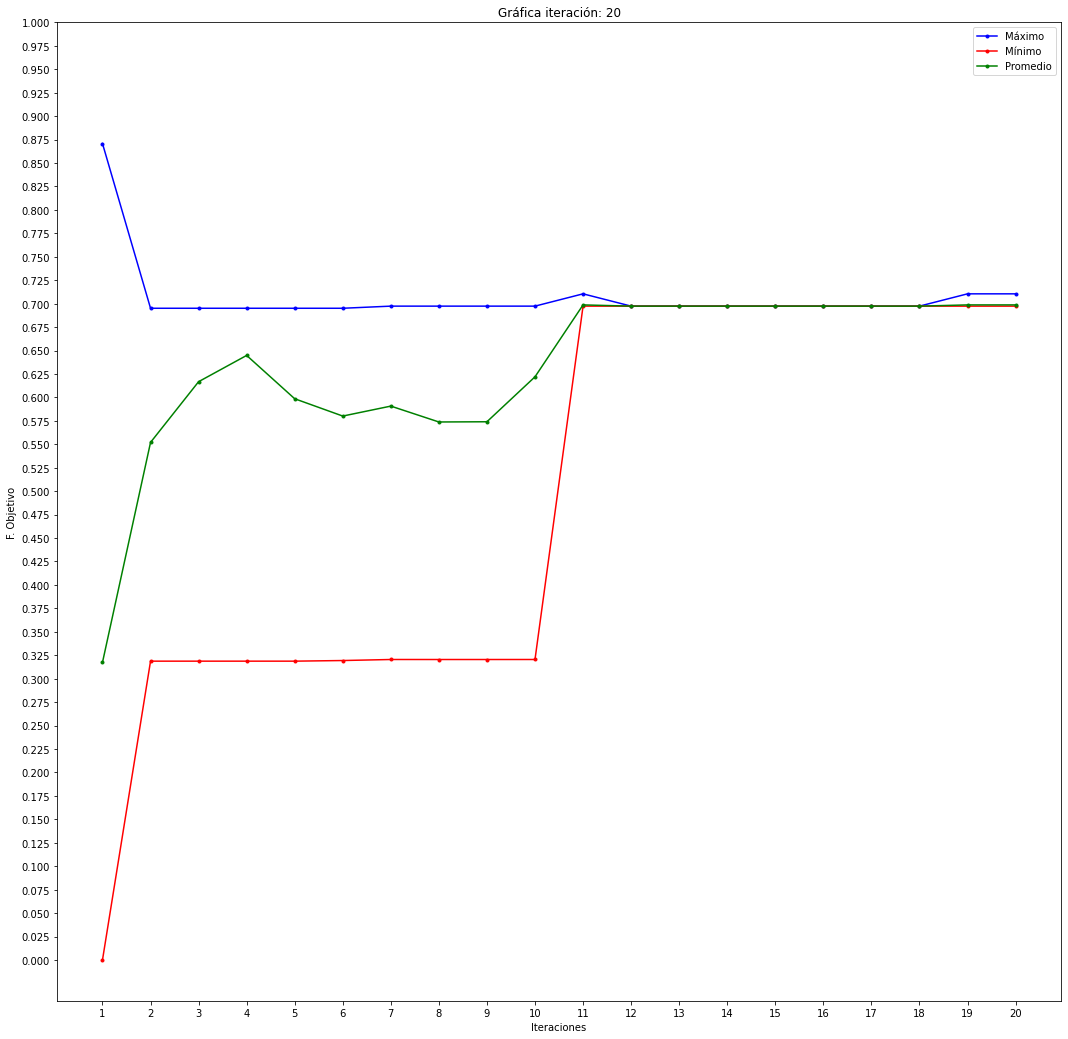

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111111000100000010111110101011,0.9709401006,0.0142289876,0.3610269491
2,111111000100000010111110101011,0.9709401006,0.1564541588,0.5756526290
3,110010101000111010001000001011,0.6260565682,0.5239255293,0.5840199649
4,110010101100010100011100101111,0.6273751936,0.5239255293,0.6017372751
5,110010101100010100011100101111,0.6273751936,0.5310588044,0.6077047896
6,110010101100010100011100101111,0.6273751936,0.5310587990,0.5996543973
7,110100111100110111001000001011,0.6845224742,0.5788810179,0.6067909504
8,110100111100110111001000001011,0.6845224742,0.5788810066,0.6079226526
9,110100111100110111001000001011,0.6845224742,0.5788810066,0.6172612253
10,110100111100110111001000001011,0.6845224742,0.5788810179,0.6136373871


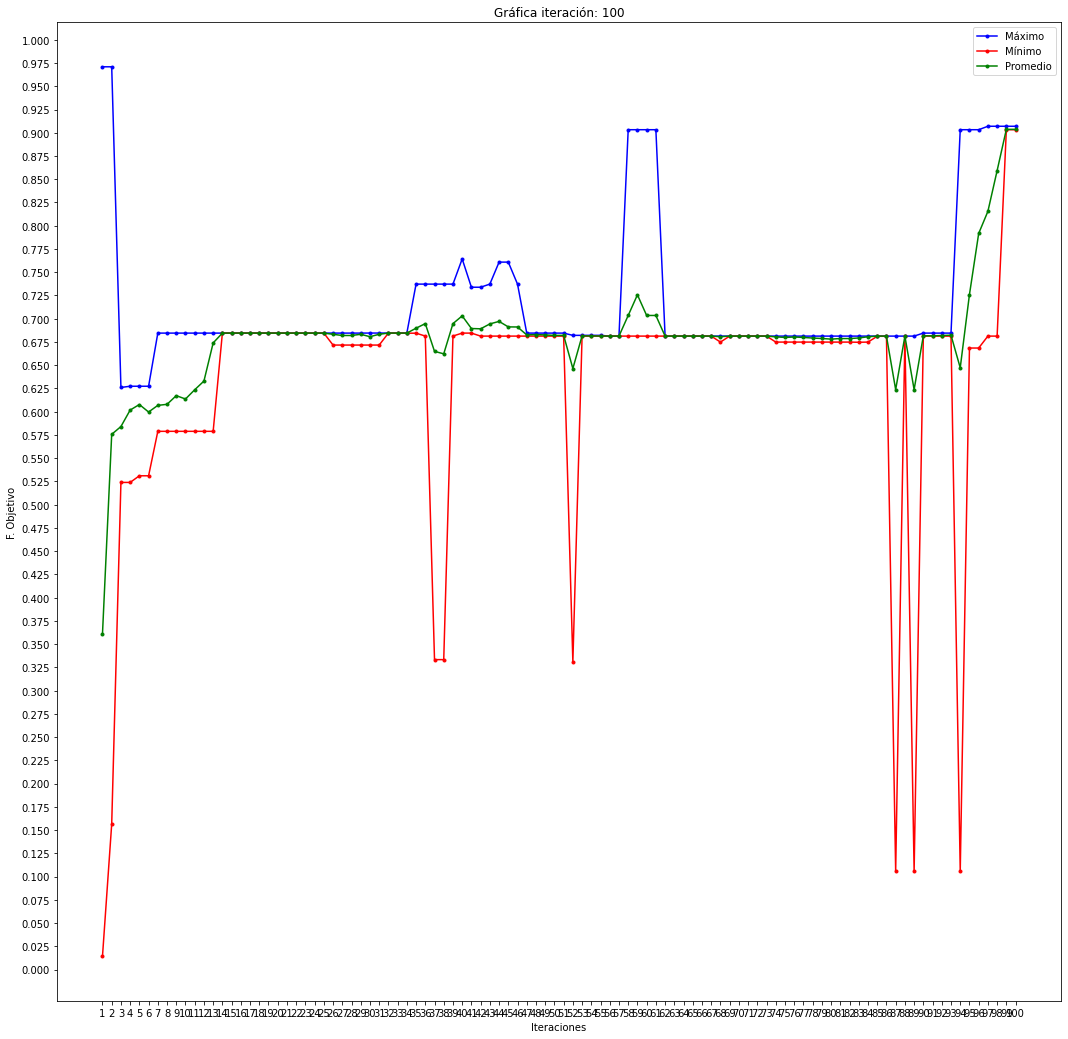

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110001001110011010001111000011,0.5915810290,0.0022891186,0.2249807009
2,111100111001000110011010110110,0.9052390340,0.0091565652,0.4768522728
3,110001001110111110101101110010,0.5917951178,0.3548465089,0.5325188469
4,110001001110111110101101110010,0.5917951178,0.5718438776,0.5798871151
5,110001001110111110101101110010,0.5917951178,0.5718438987,0.5779315038
6,110001001110111110101101110010,0.5917951178,0.5720542988,0.5818578812
7,110001001110111110101101110010,0.5917951178,0.5720514813,0.5779494256
8,110001001110111110101101110010,0.5917951178,0.5720514587,0.5779491321
9,110001001111111110101111000011,0.5921709196,0.5714745169,0.5852472578
10,110001001111111110101111000011,0.5921709196,0.5714745169,0.5851030852


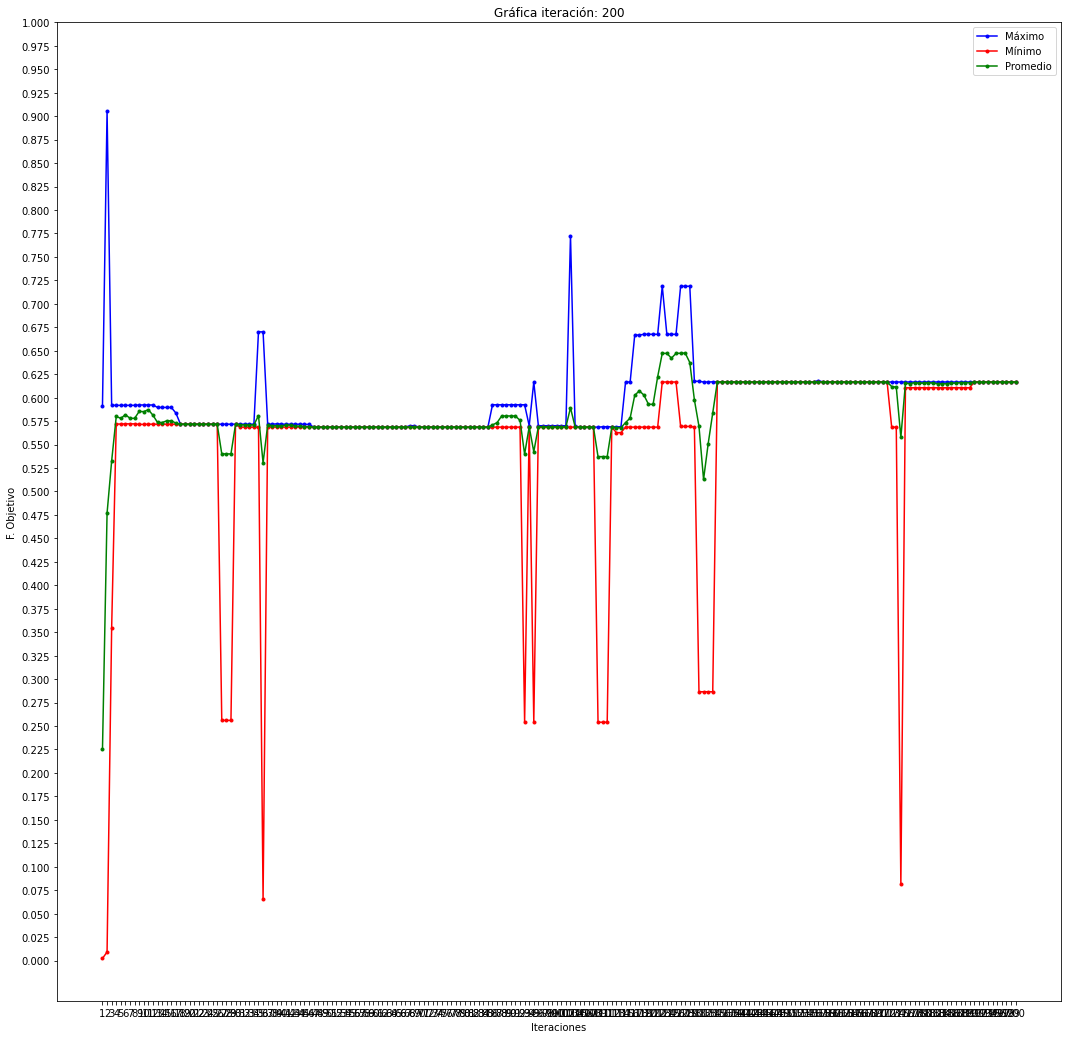

CASO B: Método selección torneo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111110000001011000010101000100,0.9391295160,0.0048789287,0.2967567477
2,111110000100100000001111101101,0.9406081878,0.3014185174,0.5828704773
3,111110000100100000001111101101,0.9406081878,0.5999076720,0.9059385341
4,111110000100100000001111101101,0.9406081878,0.9391307453,0.9404522517
5,111110000100100000001111101101,0.9406081878,0.9406081138,0.9406081804
6,111110000100100000001111101101,0.9406081878,0.9406081878,0.9406081878
7,111110000100100000001111101101,0.9406081878,0.9406081878,0.9406081878
8,111110000100100000001111101101,0.9406081878,0.9406081878,0.9406081878
9,111110000100100000001111101101,0.9406081878,0.9406081878,0.9406081878
10,111110000100100000001111101101,0.9406081878,0.9406081878,0.9406081878


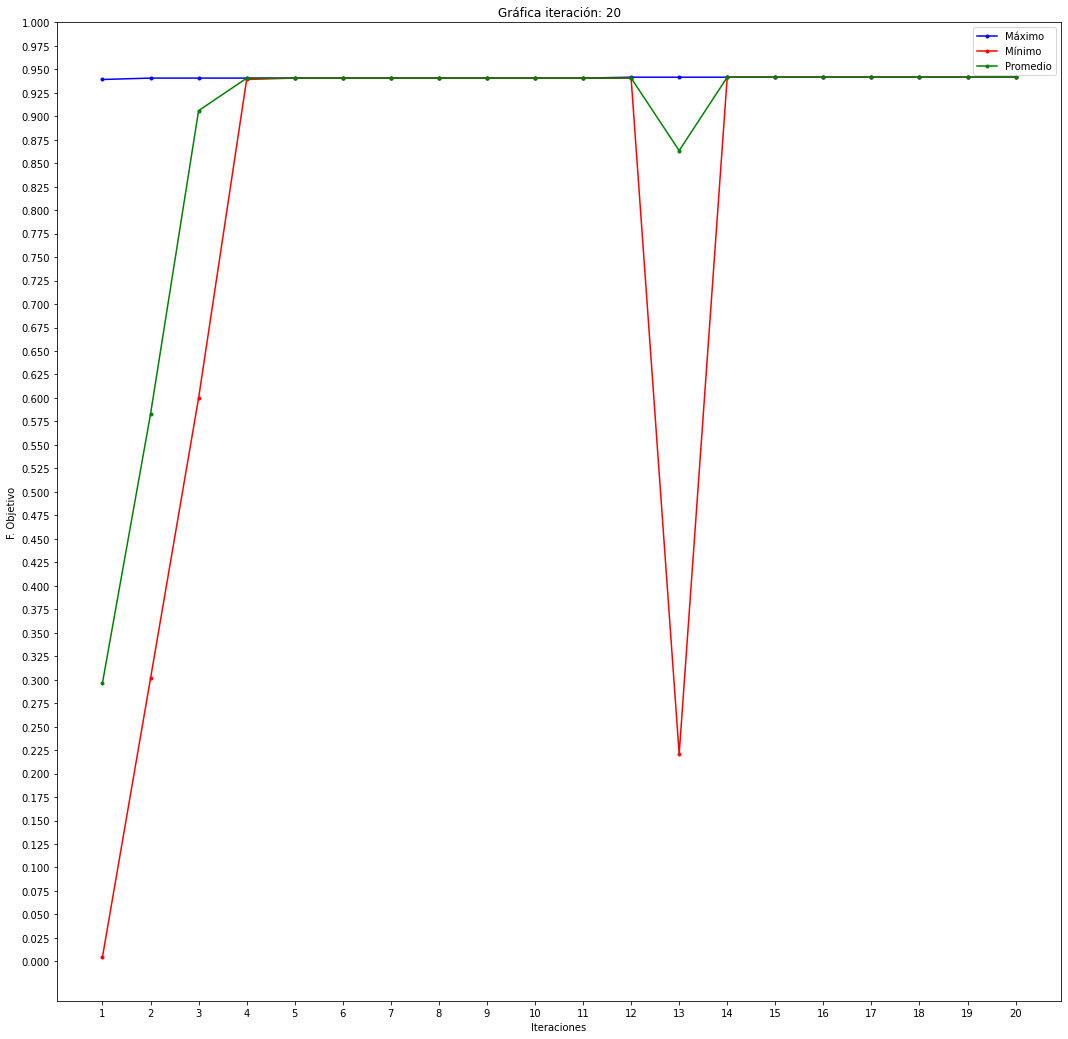

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111001000100011111000000111000,0.7951643285,0.0116131640,0.2835355290
2,111001000100011111000001100010,0.7951643983,0.0116131636,0.5390068137
3,111001000101011111000001001111,0.7955998364,0.7951642604,0.7952079092
4,111001000101011111000001001111,0.7955998364,0.7951643667,0.7954692058
5,111001000101011111100001001111,0.7956032390,0.7955998348,0.7956001765
6,111001000101011111100001001111,0.7956032390,0.7955998364,0.7956018780
7,111001000101011111100001001111,0.7956032390,0.7955998364,0.7956028881
8,111001000101011111100001001111,0.7956032390,0.1536372981,0.7314066449
9,111001000101011111100001001111,0.7956032390,0.7956032390,0.7956032390
10,111001000101011111100001001111,0.7956032390,0.7938620717,0.7954291223


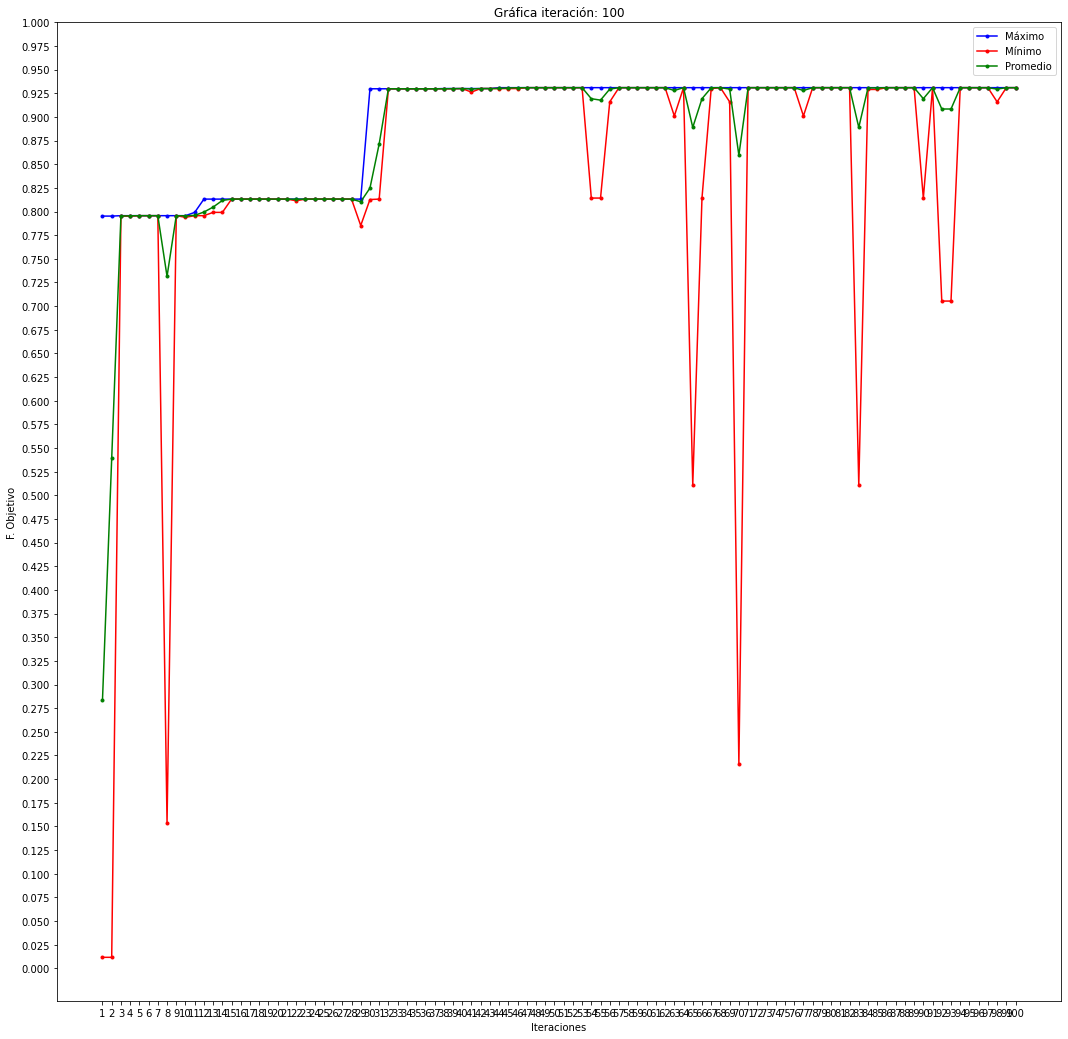

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010000001000100010001011100,0.8217611771,0.1298290415,0.4241488191
2,111010000001000111001100011101,0.8217813870,0.1298210087,0.6856136304
3,111010000001000111001100011101,0.8217813870,0.8217611738,0.8217712821
4,111010000001000111001100011101,0.8217813870,0.8217611738,0.8217772582
5,111010000001000111001100011101,0.8217813870,0.8217813870,0.8217813870
6,111010000101000111001100011101,0.8235528906,0.8217805225,0.8219584509
7,111010010001000111001100011101,0.8288788457,0.8217813870,0.8233768847
8,111010010001000111001100011101,0.8288788457,0.8217813870,0.8263941629
9,111010010001000111001100011101,0.8288788457,0.8288788457,0.8288788457
10,111010010001000111001100011101,0.8288788457,0.8288788457,0.8288788457


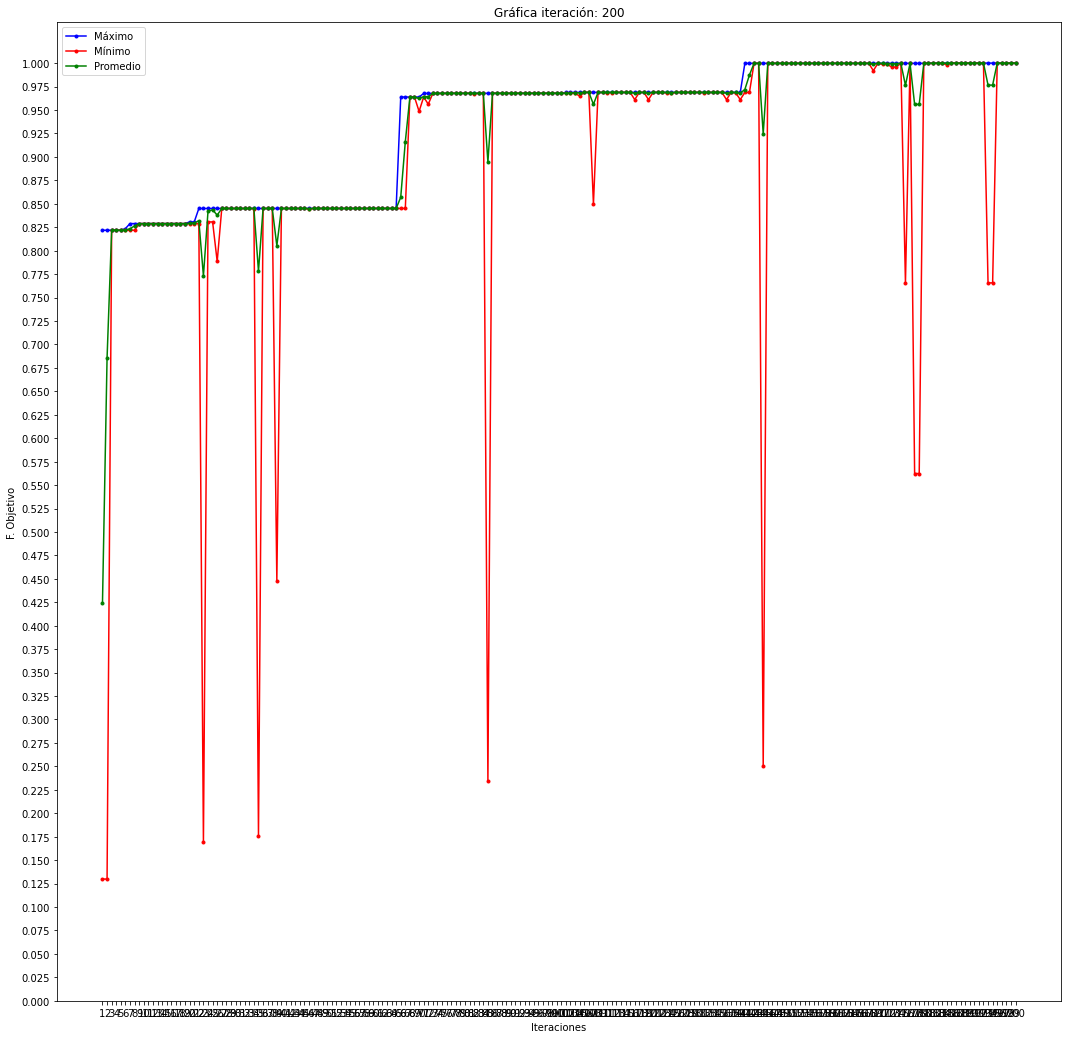

CASO C: Método selección Ruleta con elitismo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011101100101101111011011001,0.8701016423,0.0000990339,0.3868239949
2,111011101100101101111011011101,0.8701016492,0.0756370192,0.6283015777
3,111011101100101101111011011101,0.8701016492,0.1825878186,0.7568158355
4,111011101100101101111011011101,0.8701016492,0.6525310183,0.8240172570
5,111011101100101101111011011101,0.8701016492,0.8100297129,0.8512231406
6,111011101100101111010101000101,0.8701116153,0.8100393423,0.8580806827
7,111011101100101111010101000101,0.8701116153,0.8672573211,0.8698192096
8,111011101101101111010101000101,0.8705671426,0.8701016492,0.8701521850
9,111011101101101111010101000101,0.8705671426,0.8701007597,0.8702900356
10,111011101101101111010101001101,0.8705671565,0.8701007458,0.8703372926


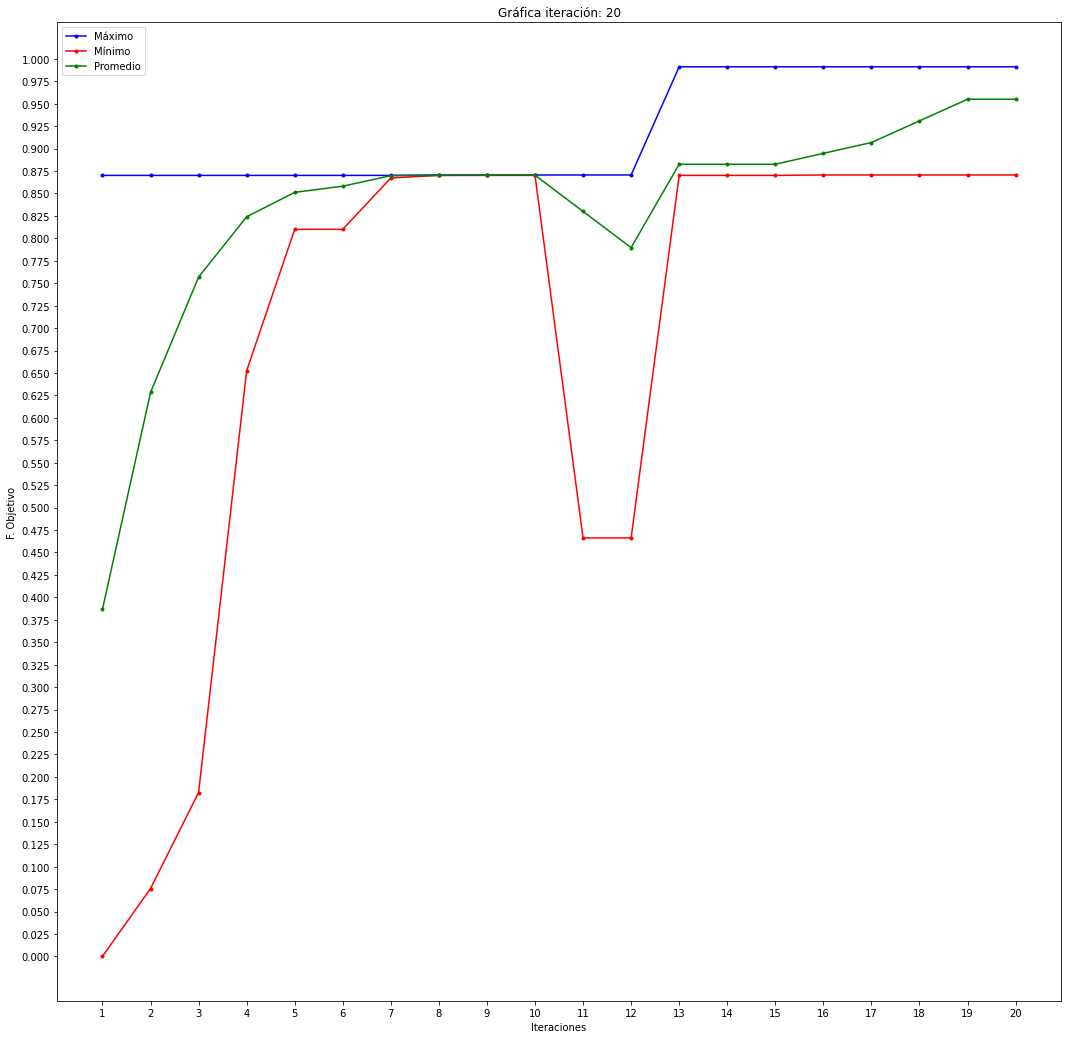

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111110101110000100101000001110,0.9603963263,0.0233169853,0.3392254300
2,111110111001111000010000111011,0.9660543686,0.2462227725,0.7138026752
3,111110111010000100101000001110,0.9661470859,0.5019918190,0.8858217247
4,111110111010000100101000001110,0.9661470859,0.8082342347,0.9316613562
5,111110111010000100111000001110,0.9661489607,0.8082342280,0.9480094202
6,111110111010000100111000001110,0.9661489607,0.8082364786,0.9468497275
7,111110111010000100111000001110,0.9661489607,0.8082364786,0.9474350450
8,111110111010000100111000001110,0.9661489607,0.5371803831,0.9191605949
9,111110111010000100111000001110,0.9661489607,0.9603028687,0.9614728377
10,111110111010000100111000001110,0.9661489607,0.9603028687,0.9620566963


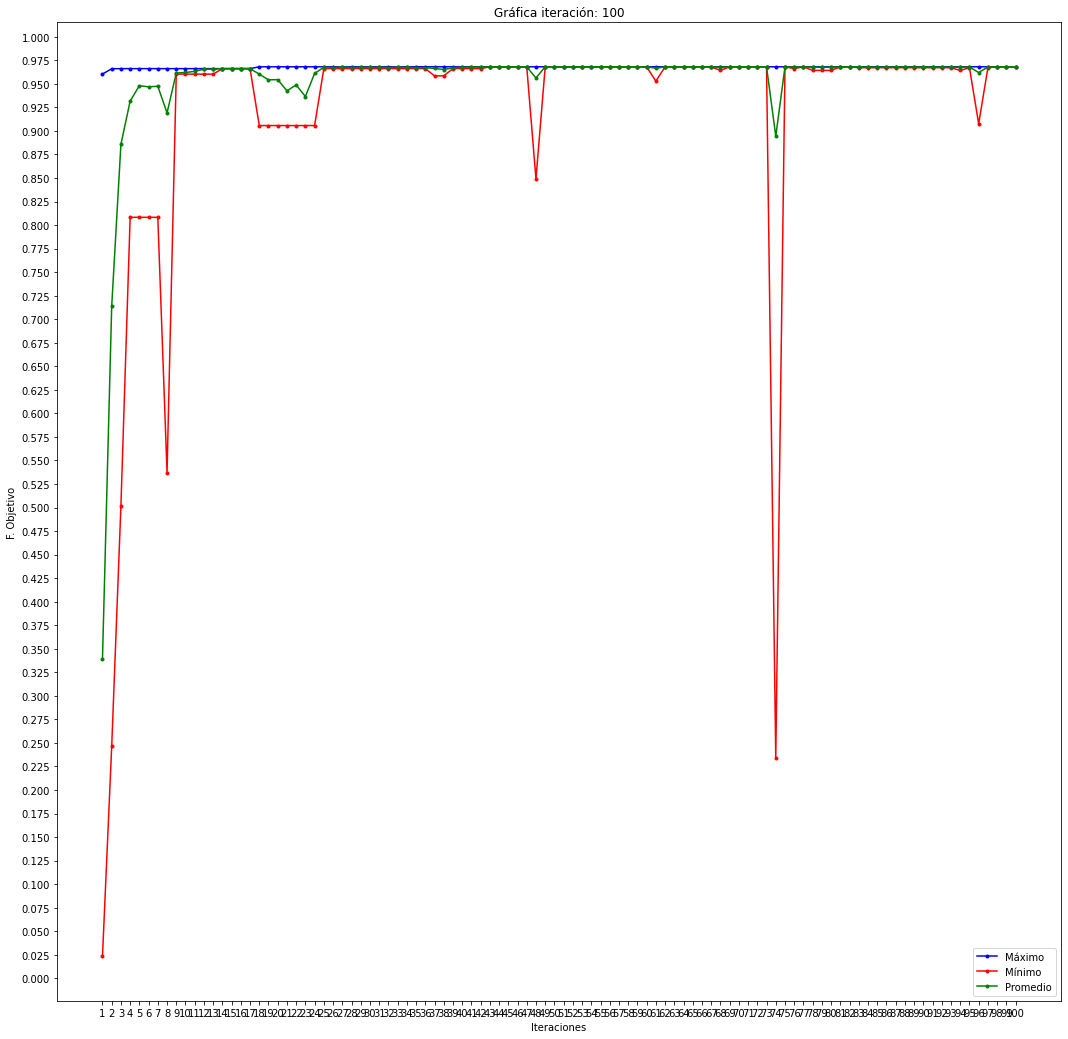

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111000110100101100010010001111,0.7883029209,0.0001217399,0.2140264530
2,111000110100101100010010111011,0.7883029936,0.0063809823,0.5120739152
3,111000110100101100010010111011,0.7883029936,0.2805926308,0.7240973930
4,111000110100101100010011001111,0.7883030267,0.6539577866,0.7748684326
5,111011110000010101101101011001,0.8717519280,0.5819619499,0.7625792498
6,111011110000010101101101011001,0.8717519280,0.5819619499,0.7927035200
7,111011110000010101101101011001,0.8717519280,0.5819618590,0.7927026202
8,111011110000010101110011001111,0.8717525785,0.7883024082,0.8300266074
9,111011110100101100010010001111,0.8737374597,0.7864170156,0.8467273552
10,111011110100101100010010001111,0.8737374597,0.7864172270,0.8467262051


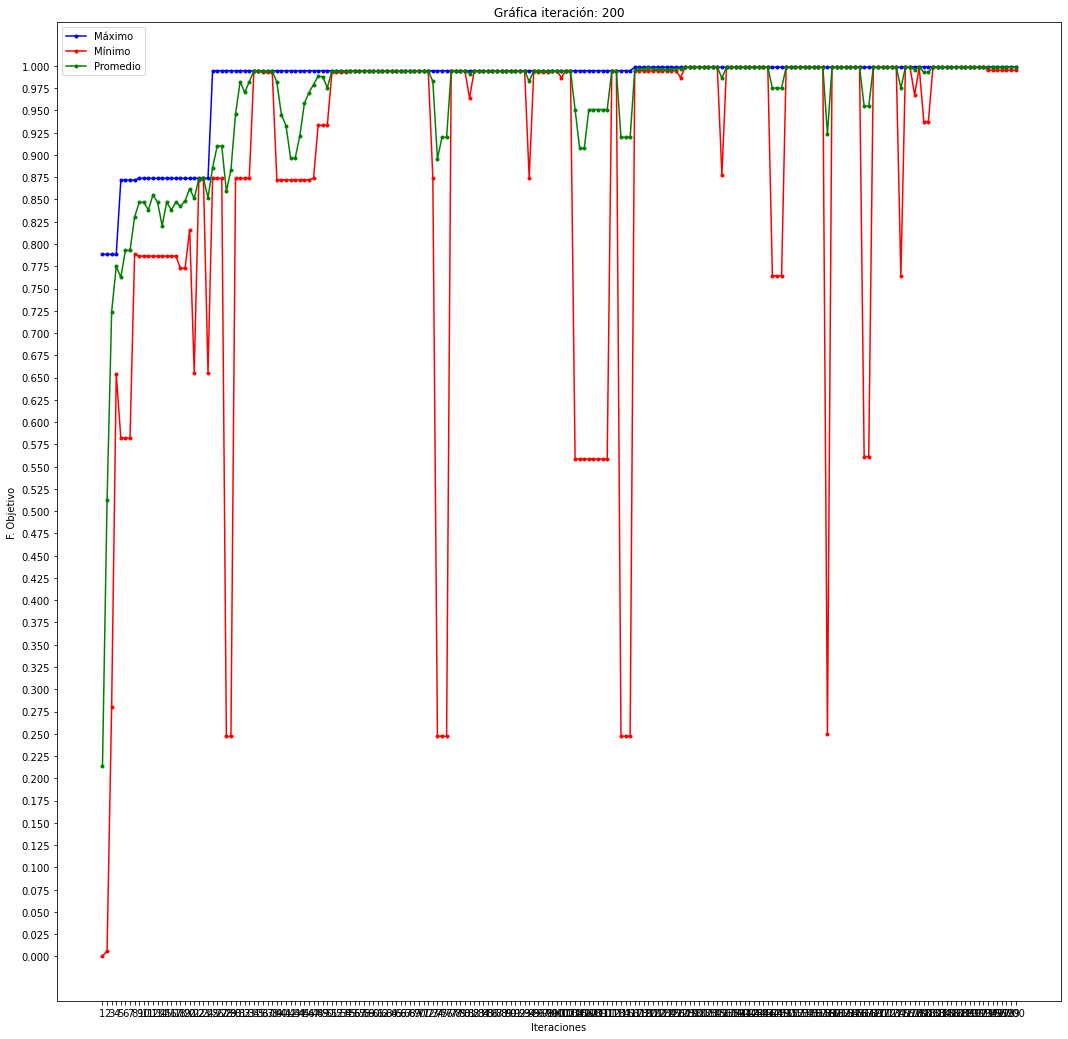

CASO C: Método selección torneo con elitismo


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010100111001111000000111101,0.8387423222,0.0347231054,0.3853178341
2,111010100111001111000000111101,0.8387423222,0.0295538817,0.6828526101
3,111010100111001111001000100110,0.8387431564,0.8244935329,0.8373164732
4,111010100111001111001000100110,0.8387431564,0.8387318414,0.8387403929
5,111010100111001111001000111101,0.8387431956,0.8387422830,0.8387429896
6,111010100111001111001000111101,0.8387431956,0.8387422830,0.8387430887
7,111010100111001111001000111101,0.8387431956,0.8387431564,0.8387431878
8,111010100111001111001000111101,0.8387431956,0.8244943989,0.8373183159
9,111010110111001111001000111101,0.8459133703,0.8387431956,0.8394602131
10,111010110111001111001000111101,0.8459133703,0.8386872988,0.8423226933


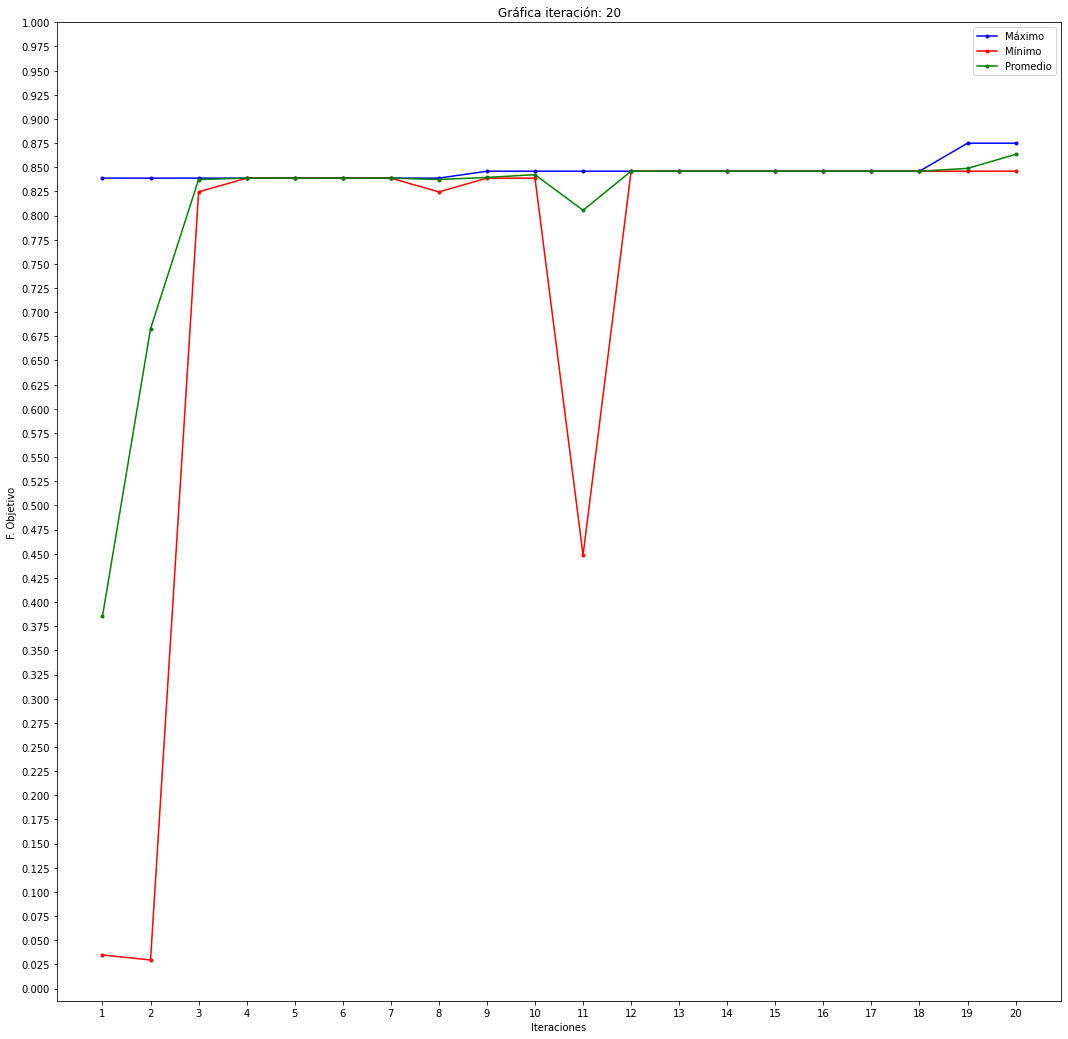

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011011010010001111011110001,0.8617243093,0.0041997626,0.3604005451
2,111110010100101100011001110011,0.9482907202,0.0041997626,0.6740147459
3,111110010100101101111011110101,0.9483021004,0.7204651675,0.8995382966
4,111110010100101101111011110101,0.9483021004,0.8617243128,0.9396374935
5,111110010100101101111011110101,0.9483021004,0.8617243128,0.9396409076
6,111110010100101101111011110101,0.9483021004,0.9482909560,0.9483009624
7,111110010100101101111011110101,0.9483021004,0.9483021004,0.9483021004
8,111110010100101101111011110101,0.9483021004,0.9483021004,0.9483021004
9,111110010100101101111011110101,0.9483021004,0.9483021004,0.9483021004
10,111110010100101101111011110101,0.9483021004,0.9483021004,0.9483021004


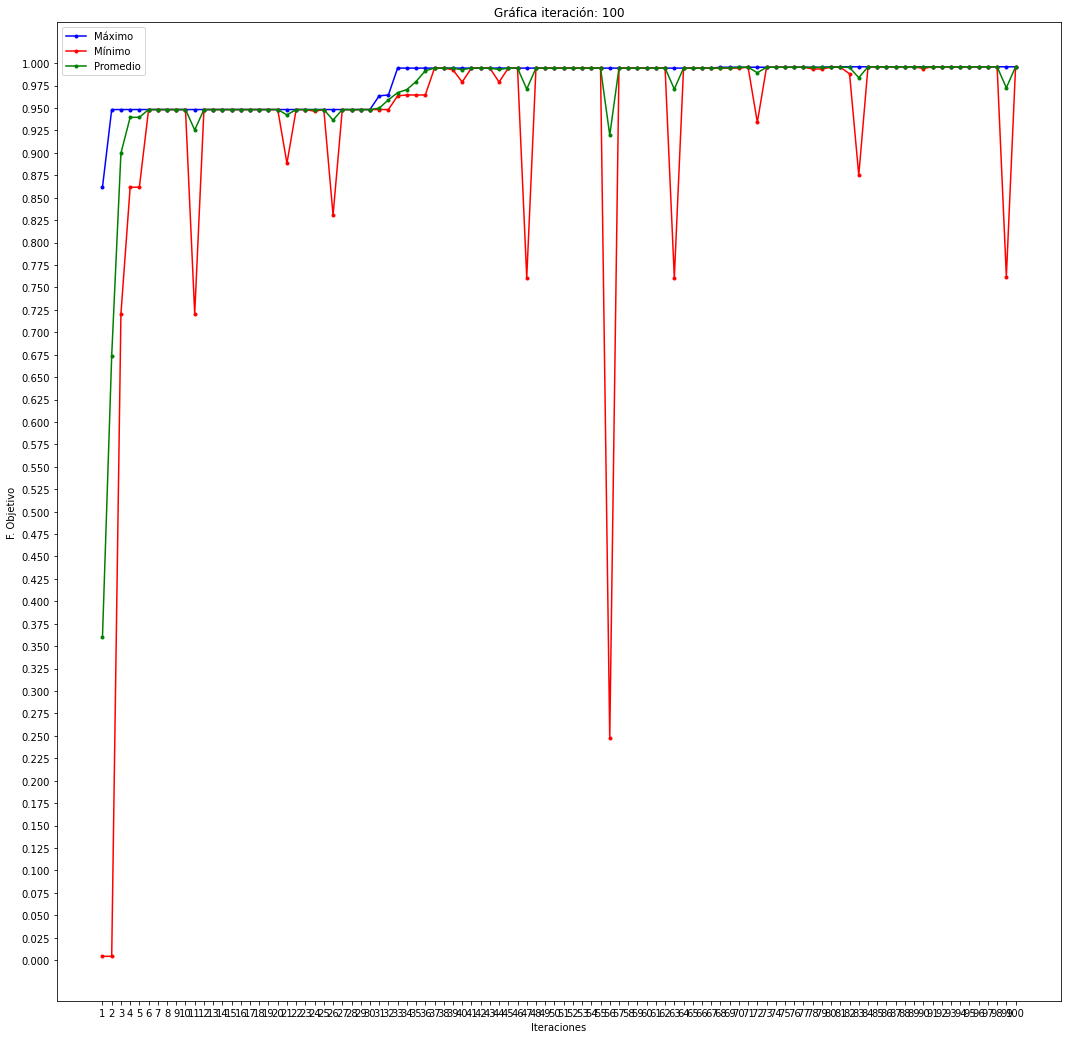

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010001110010011110110001101,0.8276335626,0.0048505933,0.4319802624
2,111010001110010011110110001101,0.8276335626,0.6081105007,0.7448020878
3,111010001110010011111001000101,0.8276338744,0.7200763087,0.7971962475
4,111010001110010011111001000101,0.8276338744,0.7383743167,0.8187077627
5,111010001110010011111001000101,0.8276338744,0.8276335626,0.8276338215
6,111010001110010011111001000101,0.8276338744,0.6158229114,0.8064527781
7,111010001110010011111001100101,0.8276339286,0.6158229114,0.8064527835
8,111010001110010011111001100101,0.8276339286,0.8276338744,0.8276338906
9,111010001110010011111001100101,0.8276339286,0.8276338744,0.8276339123
10,111010001110010011111001100101,0.8276339286,0.8276338744,0.8276339178


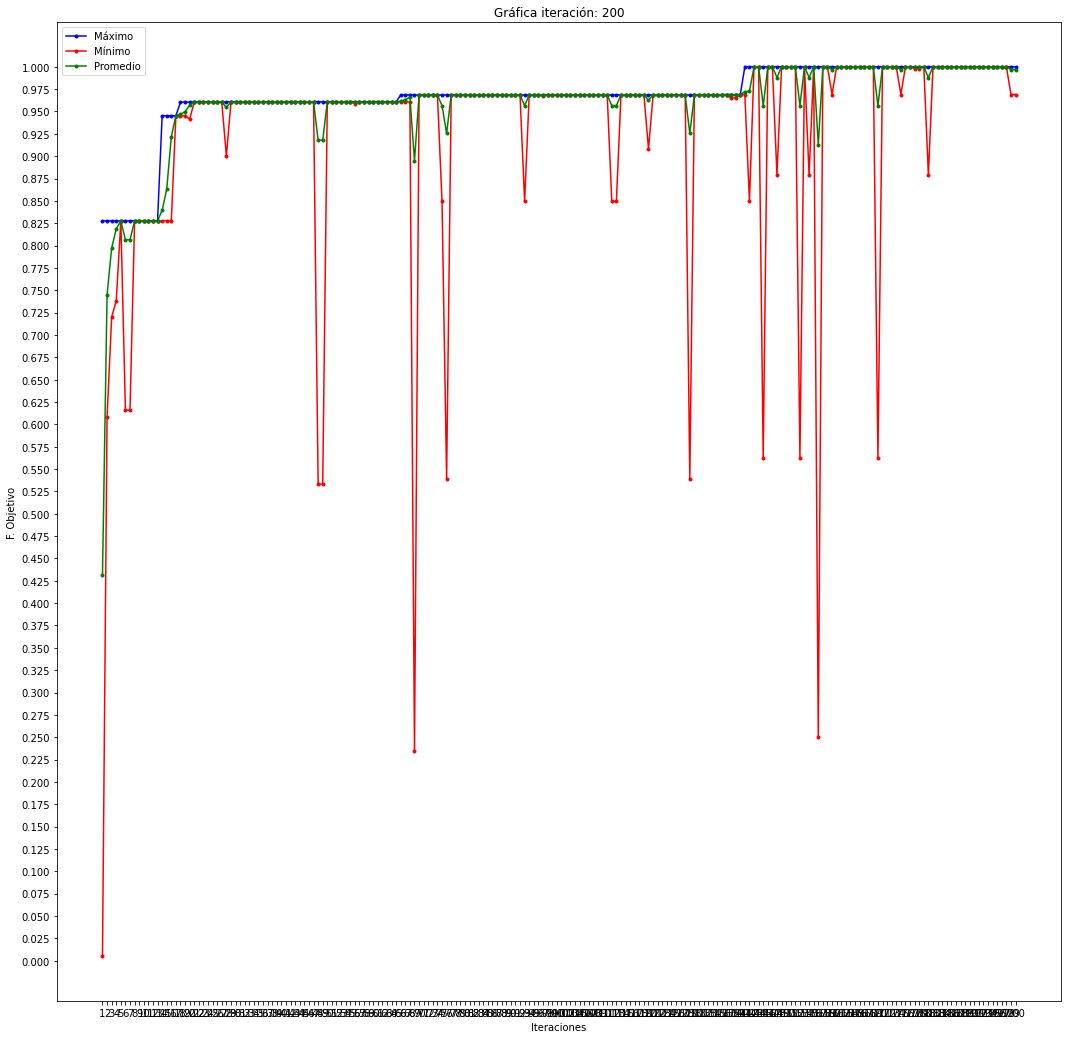

CASO A: Método selección ruleta sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111101000010110000110111000001,0.9097338044,0.0690913817,0.3985843274
2,111101011001110110010100111101,0.9205169758,0.4628926777,0.7773979507
3,111101011001110110010100111101,0.9205169758,0.4953339707,0.8704501706
4,111101011010110000110111000001,0.9209454765,0.9093079203,0.9130195769
5,111101011010110000010100111101,0.9209415798,0.9092681415,0.9118521013
6,111101011010110000010100111101,0.9209415798,0.9092681415,0.9118481000
7,111101011010110000010100100001,0.9209415297,0.9092681415,0.9129606499
8,111101011001110110110111000001,0.9205208716,0.9092681415,0.9107186039
9,111101000010110000110111001101,0.9097338257,0.9092681415,0.9095933309
10,111101000010110000110111000001,0.9097338044,0.9092681415,0.9095933288


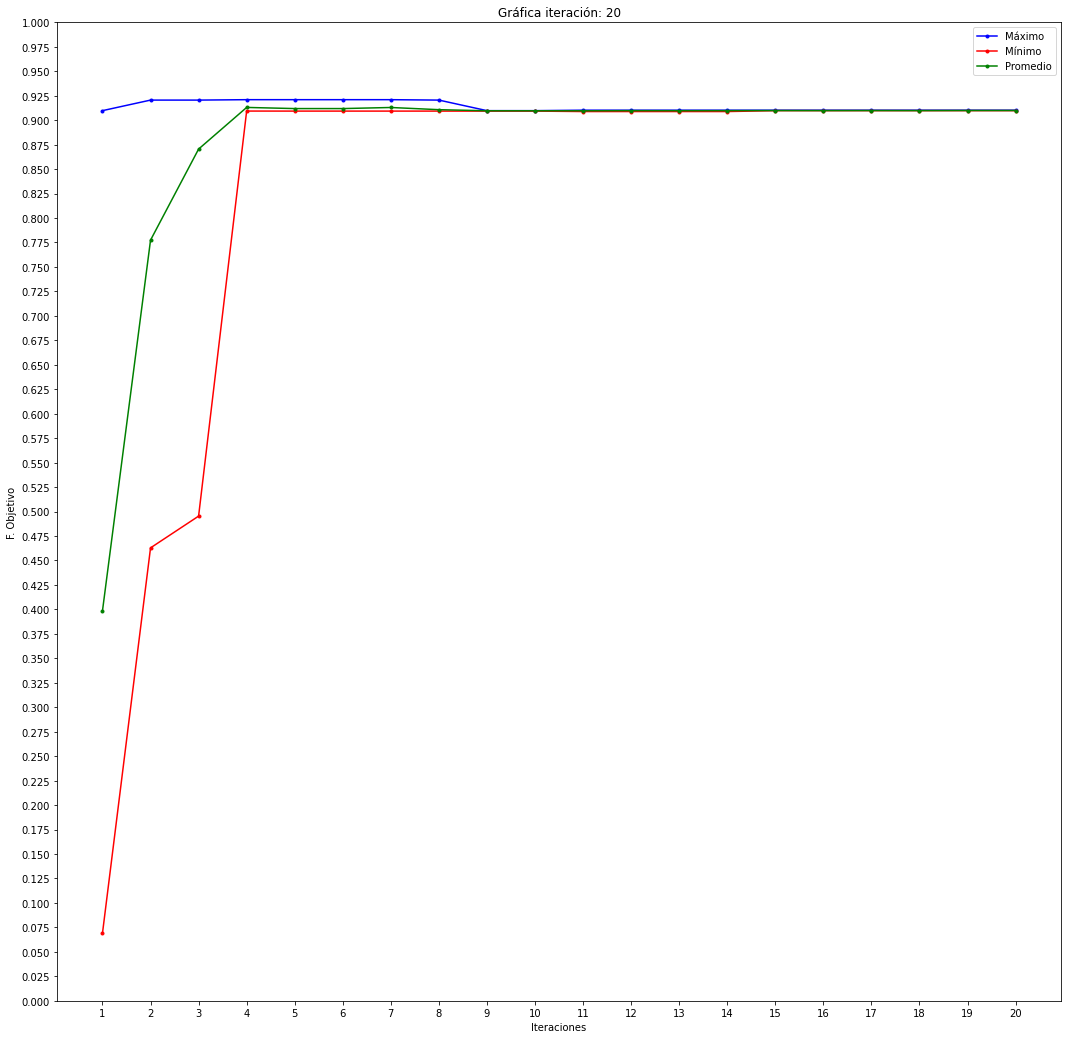

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111110011100111101011011011011,0.9522251982,0.0289530993,0.5111834940
2,111111111111111001001101000110,0.9999481577,0.3336883755,0.6309299723
3,111101111000001100001101001100,0.9347862342,0.3888515518,0.6112654241
4,111111111010001011101001000110,0.9971611541,0.3888514775,0.7235802234
5,110111111010001100000001000110,0.7631437612,0.3905923749,0.7149952340
6,110111111010001011101010000110,0.7631413660,0.3905923749,0.6987438257
7,110111111010001011101011000110,0.7631414701,0.7086927380,0.7468017179
8,110111111010001011101010000110,0.7631413660,0.7086927380,0.7466361938
9,110111111010001011101010000110,0.7631413660,0.7086927380,0.7303868869
10,110111111010001011101010000110,0.7631413660,0.7086927380,0.7357460563


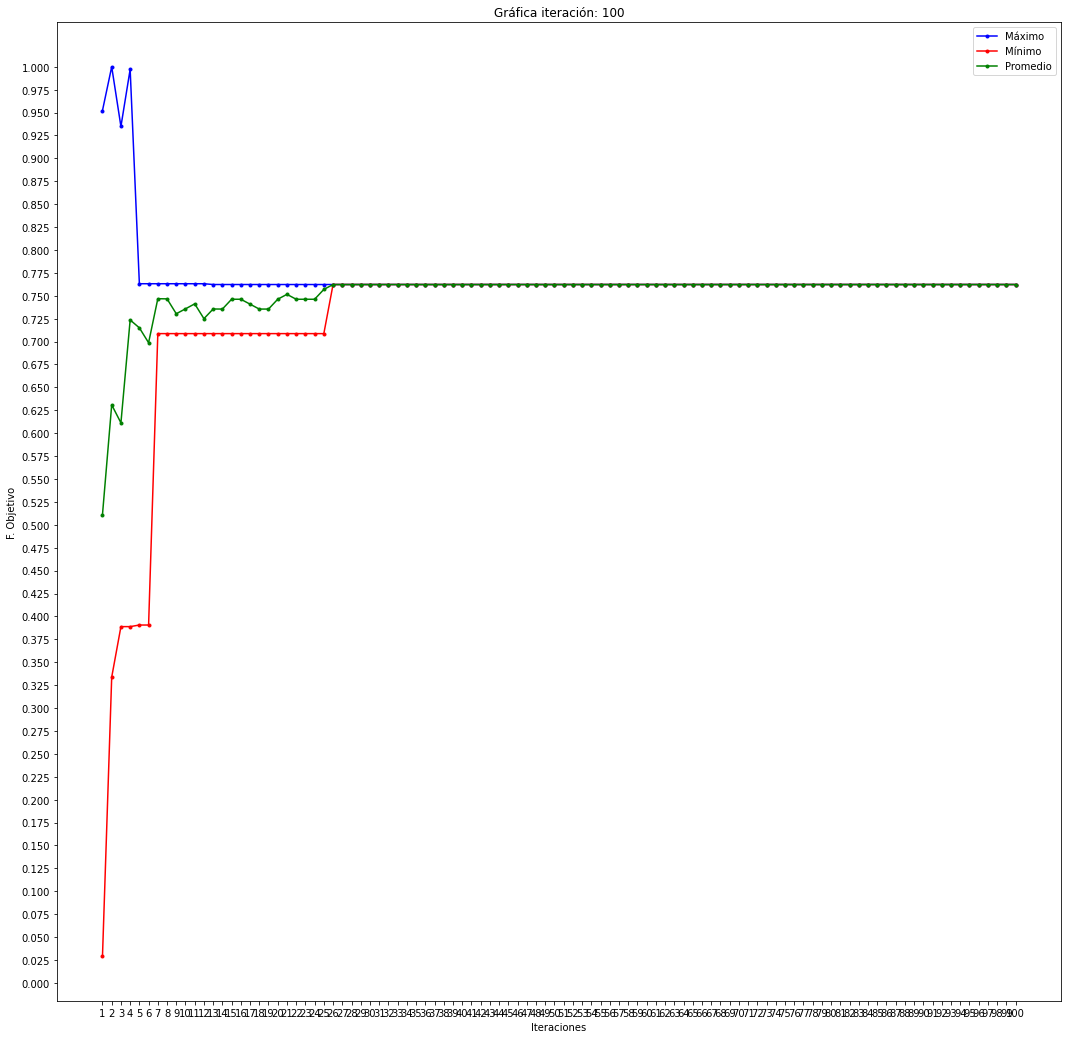

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011010011100111010101110010,0.8587056948,0.0000777958,0.2977361743
2,111011010011100111100111101100,0.8587076729,0.0156208219,0.5982610275
3,111011010101001011100111101010,0.8594148041,0.4650272860,0.8025423855
4,111011010101001011100111101010,0.8594148041,0.8024748812,0.8365063847
5,111011010101001011100101110010,0.8594145969,0.8024748846,0.8309587520
6,111011010101001011100111100100,0.8594147937,0.8024746943,0.8364796942
7,111011010101001011100111101010,0.8594148041,0.8024746943,0.8419661355
8,111011010101100111000111100010,0.8596093033,0.8024748812,0.8476060557
9,111011010011100111000111101010,0.8587041345,0.8024748812,0.8308196166
10,111011010011100111000111101010,0.8587041345,0.8024748812,0.8419887712


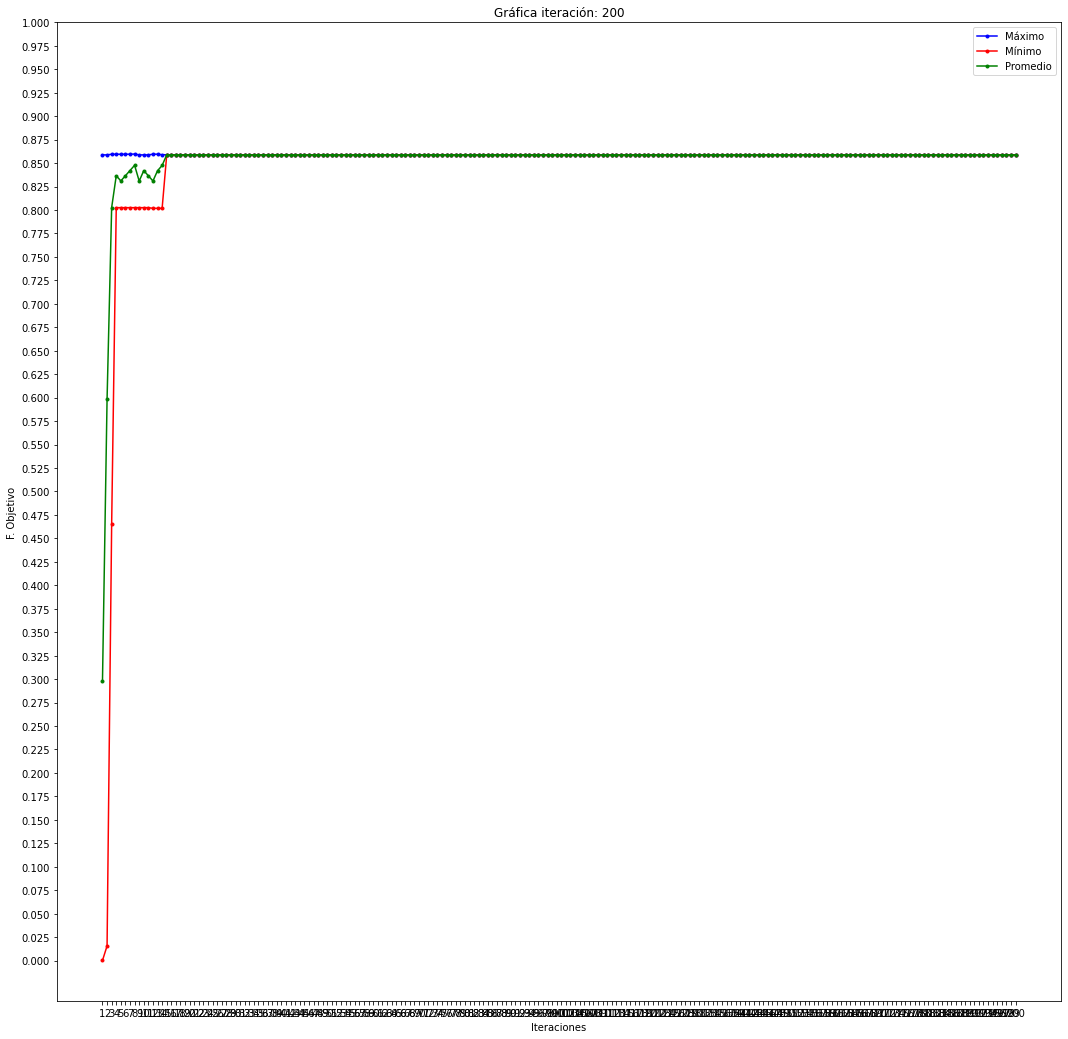

CASO B: Método selección torneo sin mutación


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101101110001101110111011110010,0.5116067820,0.0003542962,0.2668088539
2,101101110001101110111011111010,0.5116067927,0.0820513689,0.4382249405
3,101101110001101110111011111010,0.5116067927,0.4912618391,0.5095722952
4,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
5,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
6,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
7,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
8,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
9,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927
10,101101110001101110111011111010,0.5116067927,0.5116067927,0.5116067927


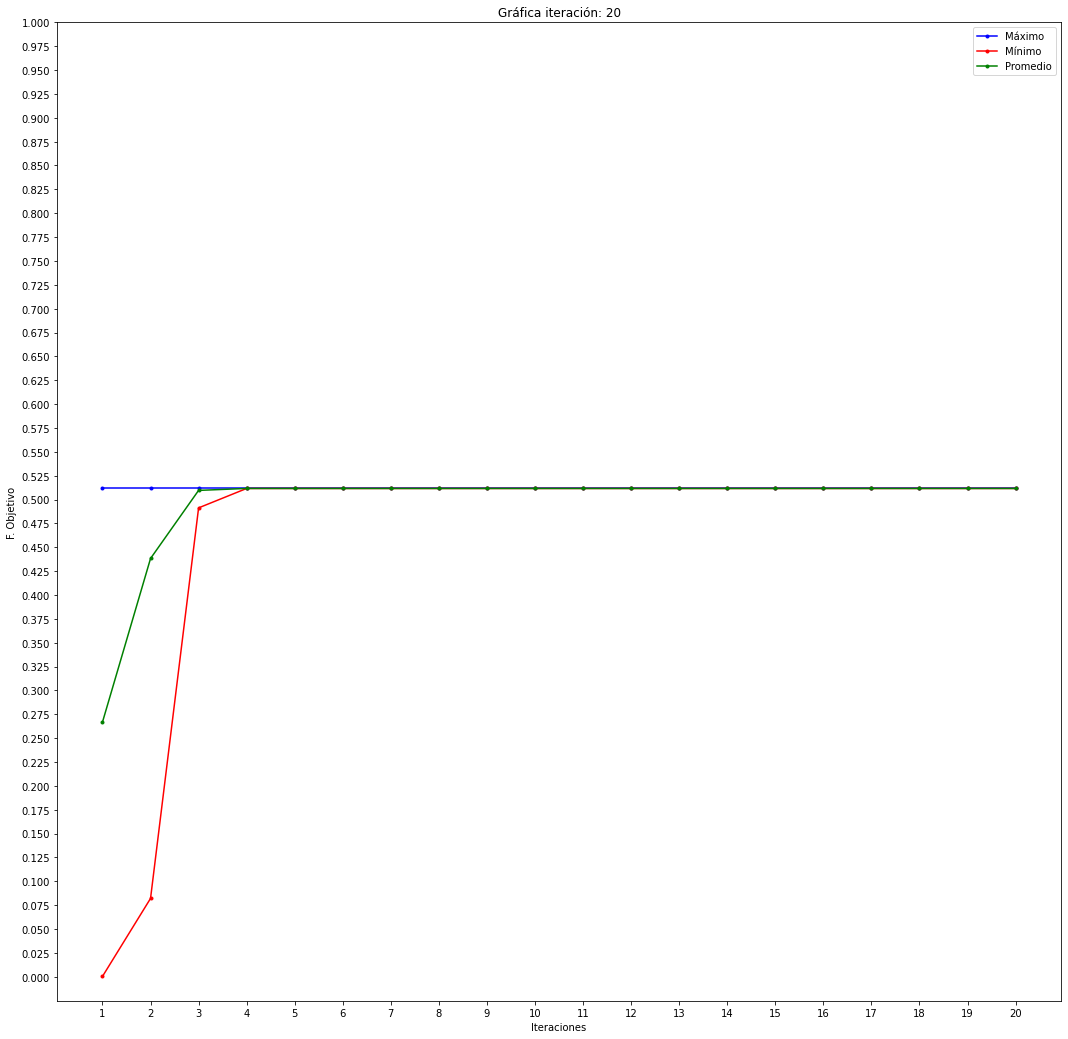

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111010001000100001000010001001,0.8250618238,0.0195559243,0.2515012159
2,111011001001100000110000101000,0.8541405293,0.0635438917,0.7037215185
3,111011001001100000110000101000,0.8541405293,0.8250618238,0.8454173623
4,111011001001100000110000101000,0.8541405293,0.8250662075,0.8512330918
5,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293
6,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293
7,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293
8,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293
9,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293
10,111011001001100000110000101000,0.8541405293,0.8541405293,0.8541405293


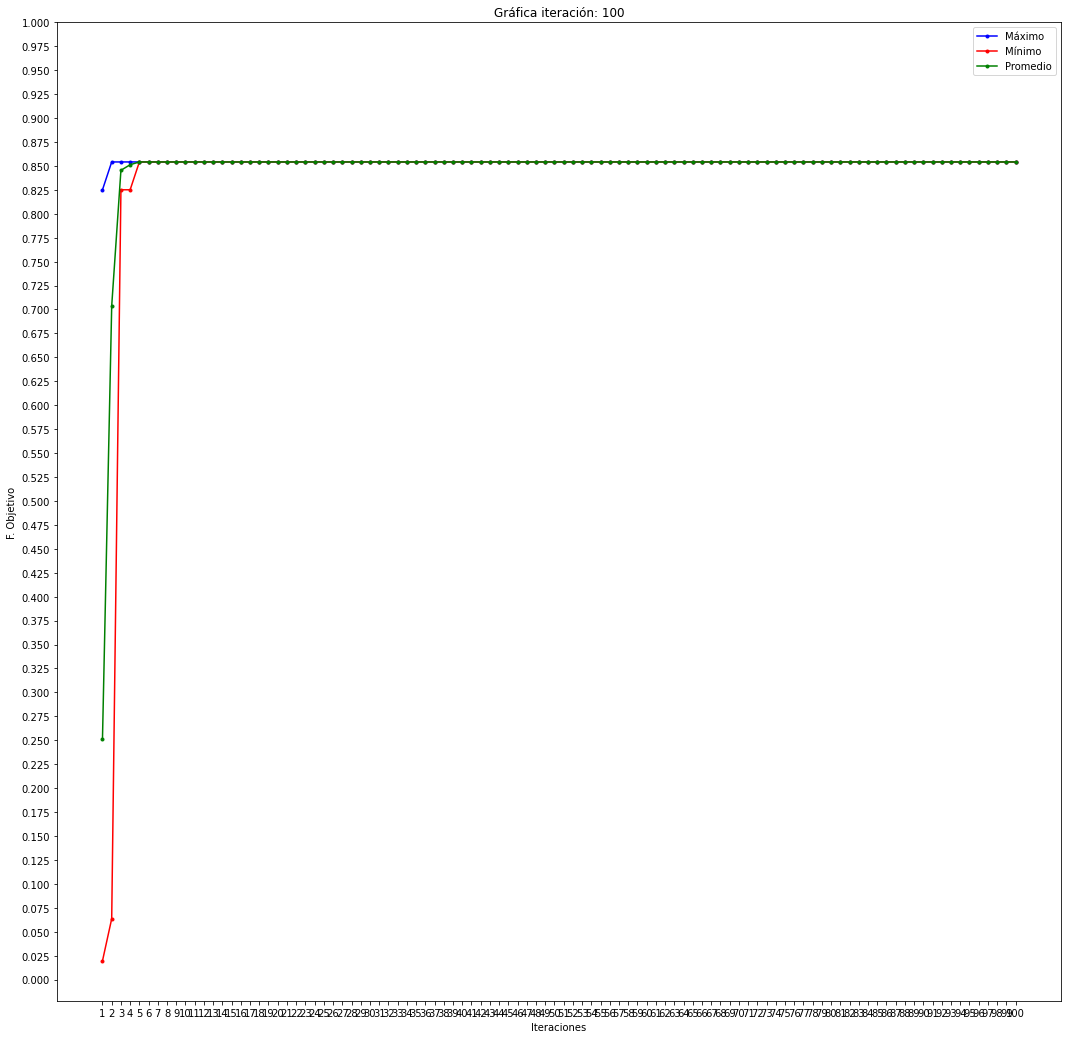

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111001011100001000100001001001,0.8054944591,0.0009282720,0.1861935271
2,111001111100110110101111111110,0.8198981796,0.0524260270,0.5640288930
3,111001111100110110101111111110,0.8198981796,0.4296559398,0.7404090244
4,111001111100110110101111111110,0.8198981796,0.4296570337,0.7808740650
5,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796
6,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796
7,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796
8,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796
9,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796
10,111001111100110110101111111110,0.8198981796,0.8198981796,0.8198981796


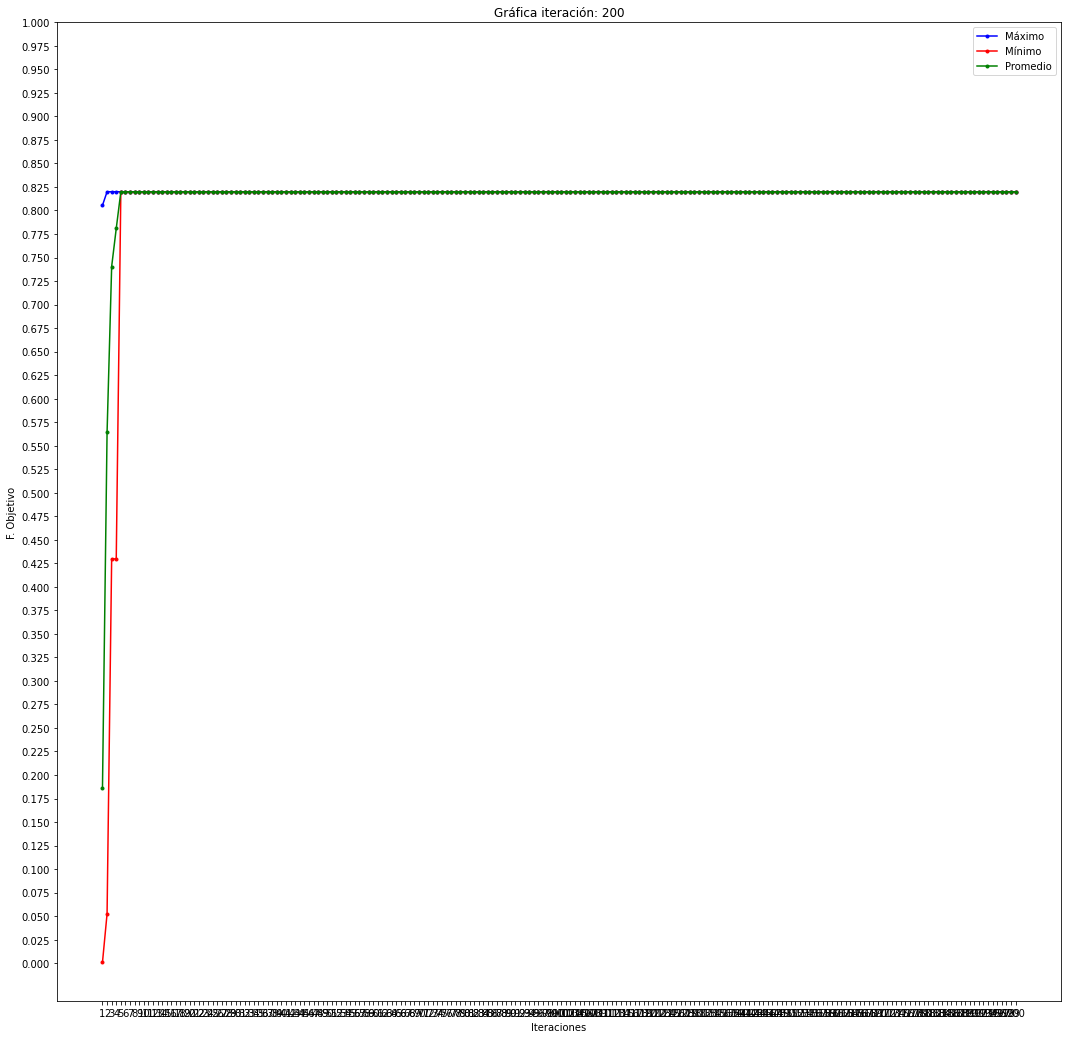

CASO C: Método selección Ruleta con elitismo sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111101111010101101010110110011,0.9359753249,0.0428871032,0.5449269111
2,111101111010101101010110110011,0.9359753249,0.4895102379,0.6981919741
3,111101111010101101010110110111,0.9359753321,0.5273611446,0.7745138896
4,111101111010101101010110110111,0.9359753321,0.5273611446,0.8227086109
5,111101111010101101010110110111,0.9359753321,0.5273611446,0.8349721765
6,111110101001010011110001000111,0.9581182958,0.8188921376,0.8975775265
7,111110101001010011110001000111,0.9581182958,0.8188917297,0.8975801087
8,111110101001010011110001000111,0.9581182958,0.8188923500,0.9070482143
9,111110101001010011110001000111,0.9581182958,0.8396701490,0.9111820498
10,111110101001010011110110110111,0.9581189667,0.8396701490,0.9134624661


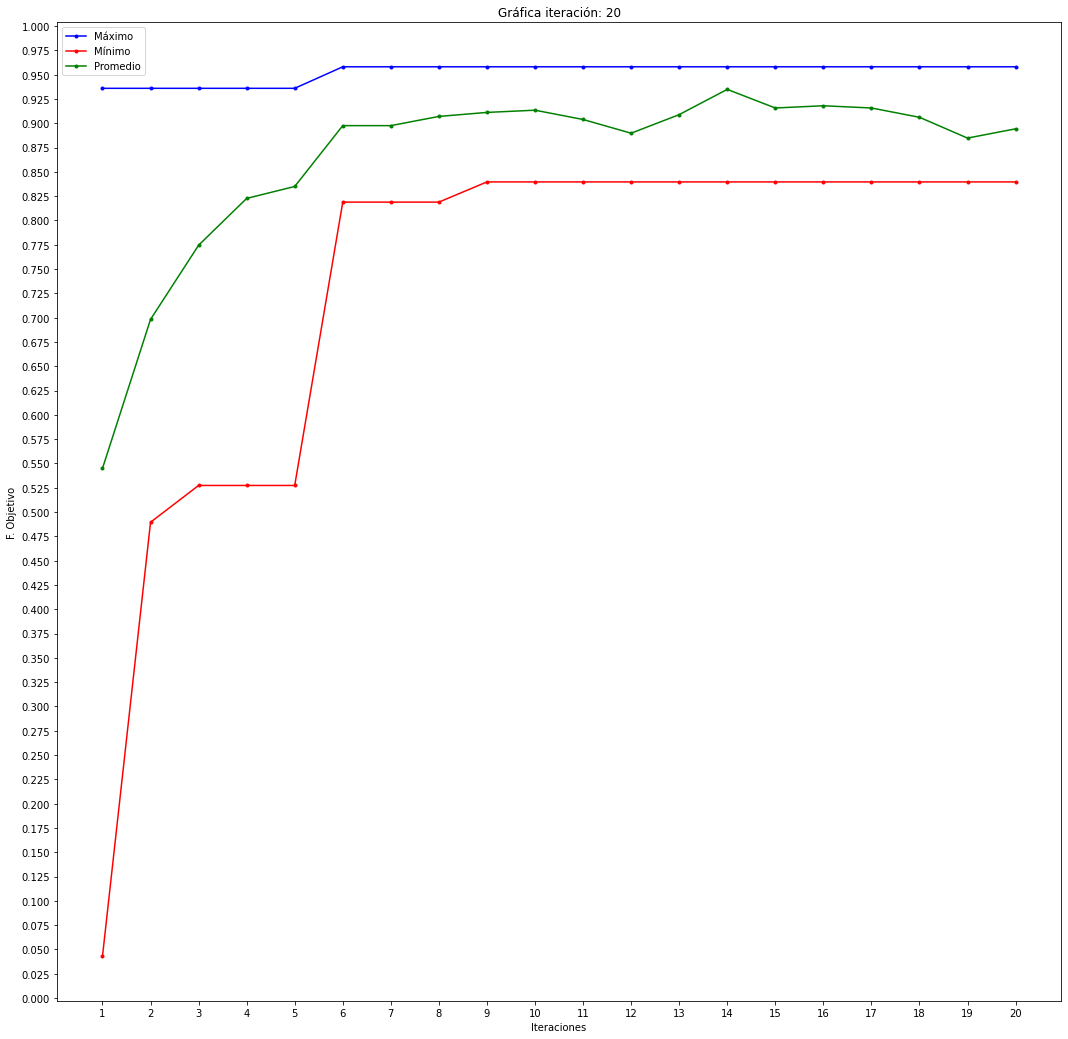

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111011010110010100000000111010,0.8599269125,0.0037489101,0.3745678535
2,111011010110010100000011000100,0.8599271509,0.2103351338,0.5579600903
3,111011010110010100000011000100,0.8599271509,0.4812968588,0.5764525238
4,111011010110010100000011000100,0.8599271509,0.5007788090,0.6846694680
5,111011010110010111110111110110,0.8599542105,0.5007788946,0.7533046626
6,111011010110010111110111110110,0.8599542105,0.5020750882,0.8236802350
7,111011010110010111110111110110,0.8599542105,0.5020750882,0.8234373506
8,111011010110010111110111110110,0.8599542105,0.5473374364,0.8222881988
9,111011010110010111110111110110,0.8599542105,0.5472469410,0.8169344117
10,111011010110010111110111110110,0.8599542105,0.8029460526,0.8540729097


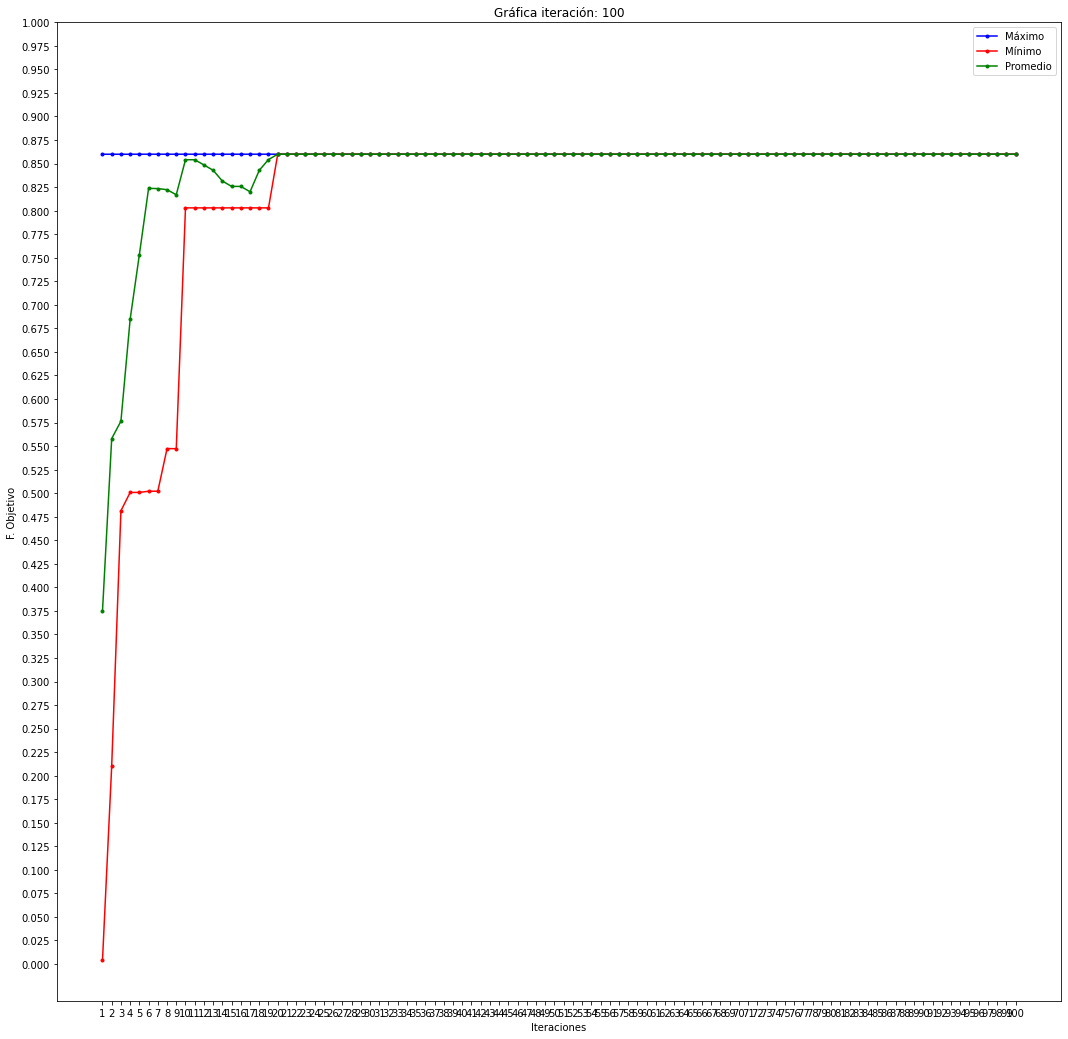

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,101100011010111011101101011001,0.4817407019,0.0002955867,0.1120866515
2,101100011010111011101101011001,0.4817407019,0.0542883174,0.3123244416
3,101100011010111111001111001001,0.4817593807,0.1278259688,0.4109532772
4,101100011010111111001111001001,0.4817593807,0.1279132707,0.4463466184
5,101100011010111111001111001001,0.4817593807,0.4815899403,0.4817180211
6,101100011010111111101101011001,0.4817618836,0.4815899403,0.4817198890
7,101100011010111111101101011001,0.4817618836,0.4815897955,0.4817050631
8,101100011010111111101111001001,0.4817620284,0.4815899403,0.4817204185
9,101100011010111111101111001001,0.4817620284,0.4815897955,0.4816889278
10,101100011010111111101111001001,0.4817620284,0.4815897955,0.4817191236


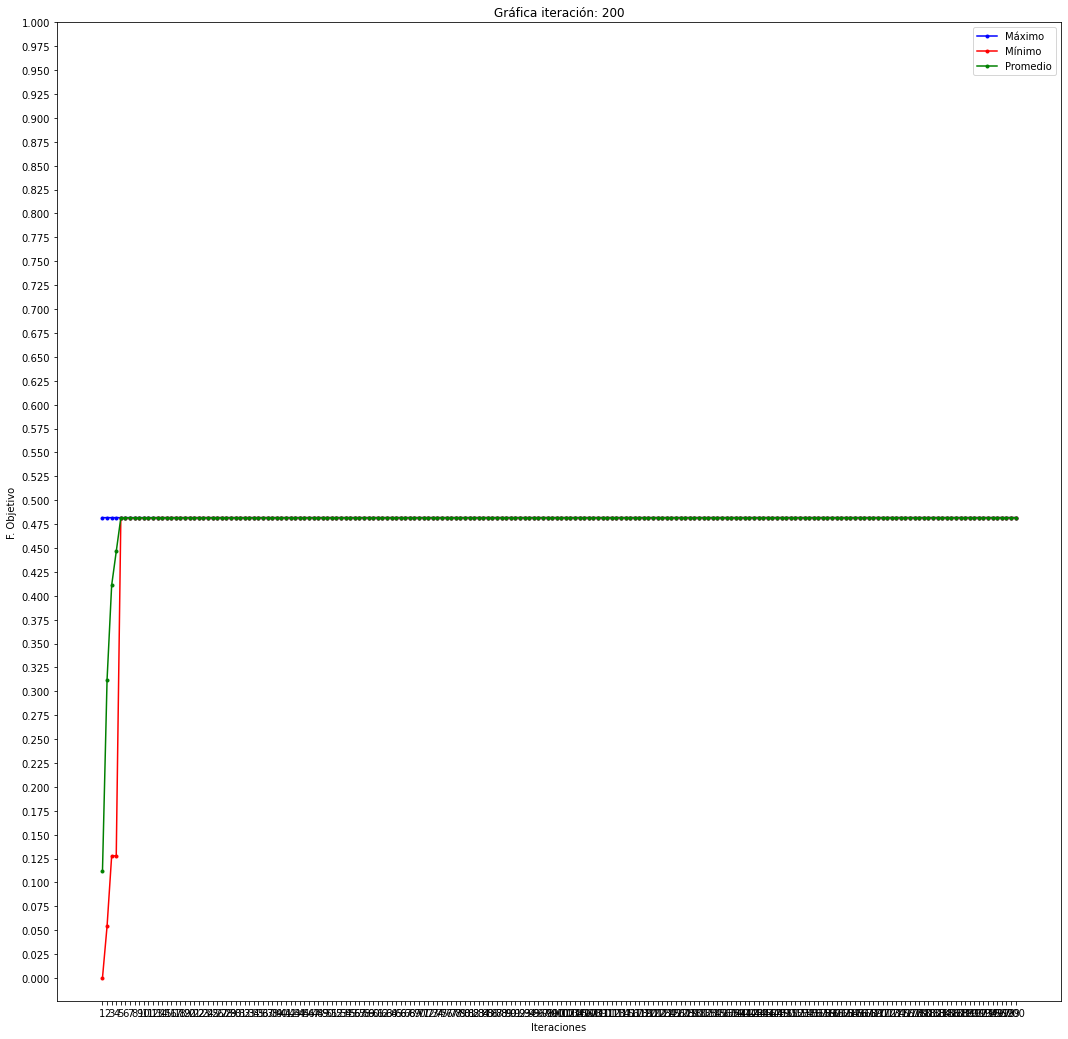

CASO C: Método selección torneo con elitismo sin mutacion


Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110111111111101110010101100111,0.7655070970,0.0004302872,0.2192471784
2,110111111111110101111010110010,0.7655577013,0.0402274681,0.5377540570
3,110111111111110101111010110111,0.7655577095,0.5768111864,0.7277932275
4,110111111111110101111010110111,0.7655577095,0.5768111864,0.7466779935
5,110111111111110101111010110111,0.7655577095,0.7655577013,0.7655577079
6,110111111111110101111010110111,0.7655577095,0.7655577095,0.7655577095
7,110111111111110101111010110111,0.7655577095,0.7655577095,0.7655577095
8,110111111111110101111010110111,0.7655577095,0.7655577095,0.7655577095
9,110111111111110101111010110111,0.7655577095,0.7655577095,0.7655577095
10,110111111111110101111010110111,0.7655577095,0.7655577095,0.7655577095


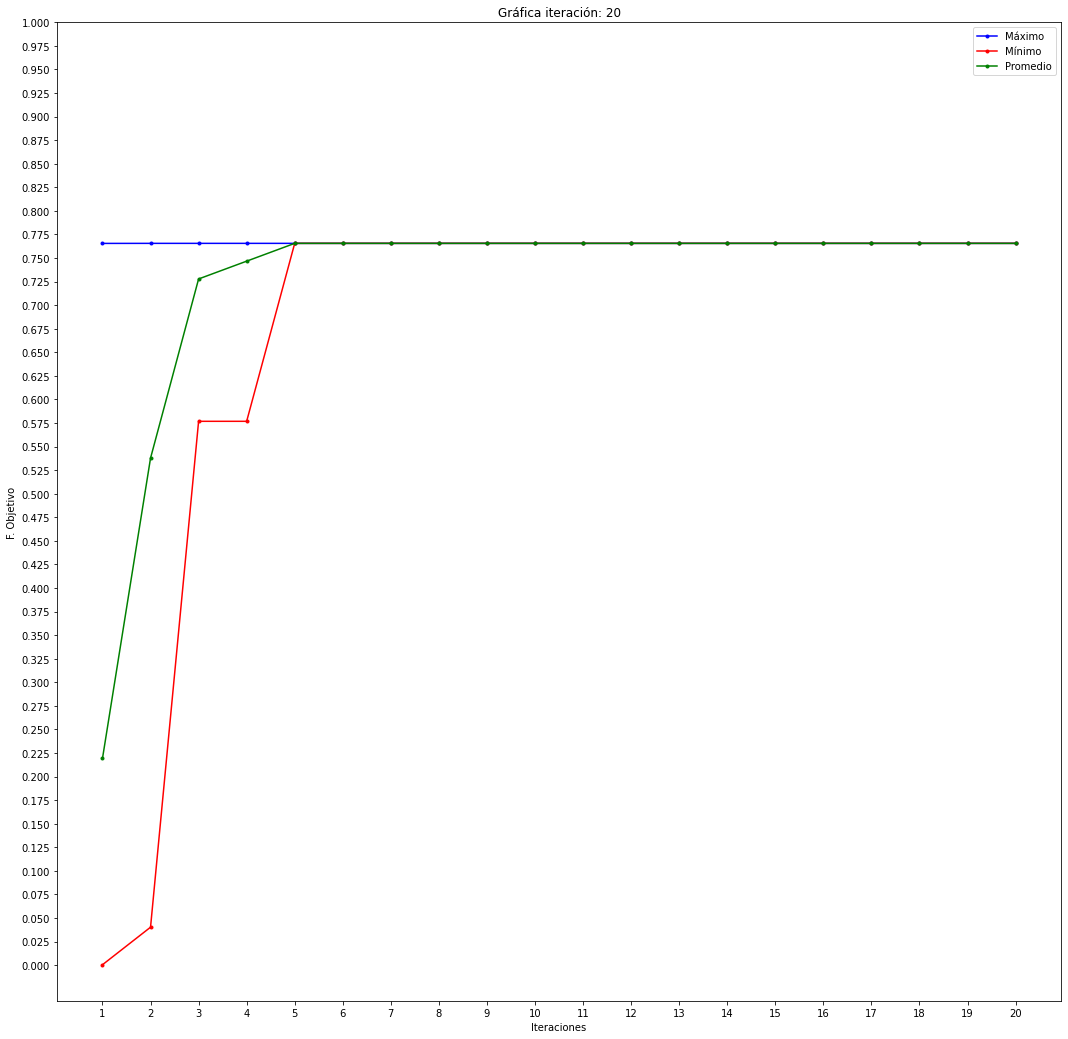

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,111101010110010011100010001110,0.9188576210,0.0042557054,0.3396782688
2,111101010110011001110110011001,0.9189038066,0.1611554439,0.8067060084
3,111101010110011001110110011100,0.9189038119,0.8954404233,0.9165380816
4,111101010110011001110110011100,0.9189038119,0.9188576210,0.9188958088
5,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119
6,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119
7,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119
8,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119
9,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119
10,111101010110011001110110011100,0.9189038119,0.9189038119,0.9189038119


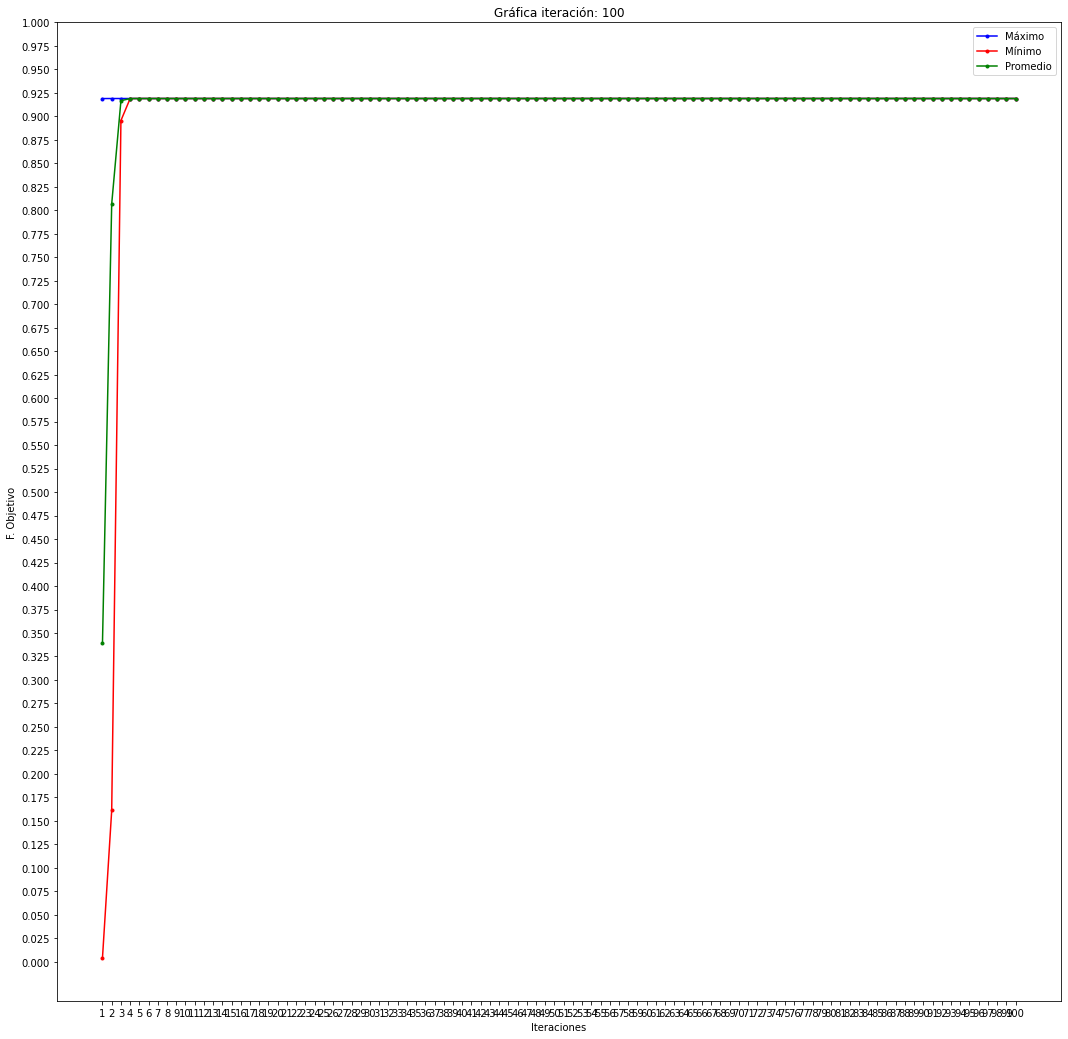

Iteracion,CromosomaMax,Maximo,Minimo,Promedio
1,110111111111011111011110001011,0.7654078652,0.0037684056,0.2738075225
2,110111111111011111011110001011,0.7654078652,0.2579061003,0.4548392660
3,110111111111011111011110001011,0.7654078652,0.2657411922,0.6642810998
4,110111111111011111011110001011,0.7654078652,0.3904699078,0.7101808156
5,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652
6,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652
7,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652
8,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652
9,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652
10,110111111111011111011110001011,0.7654078652,0.7654078652,0.7654078652


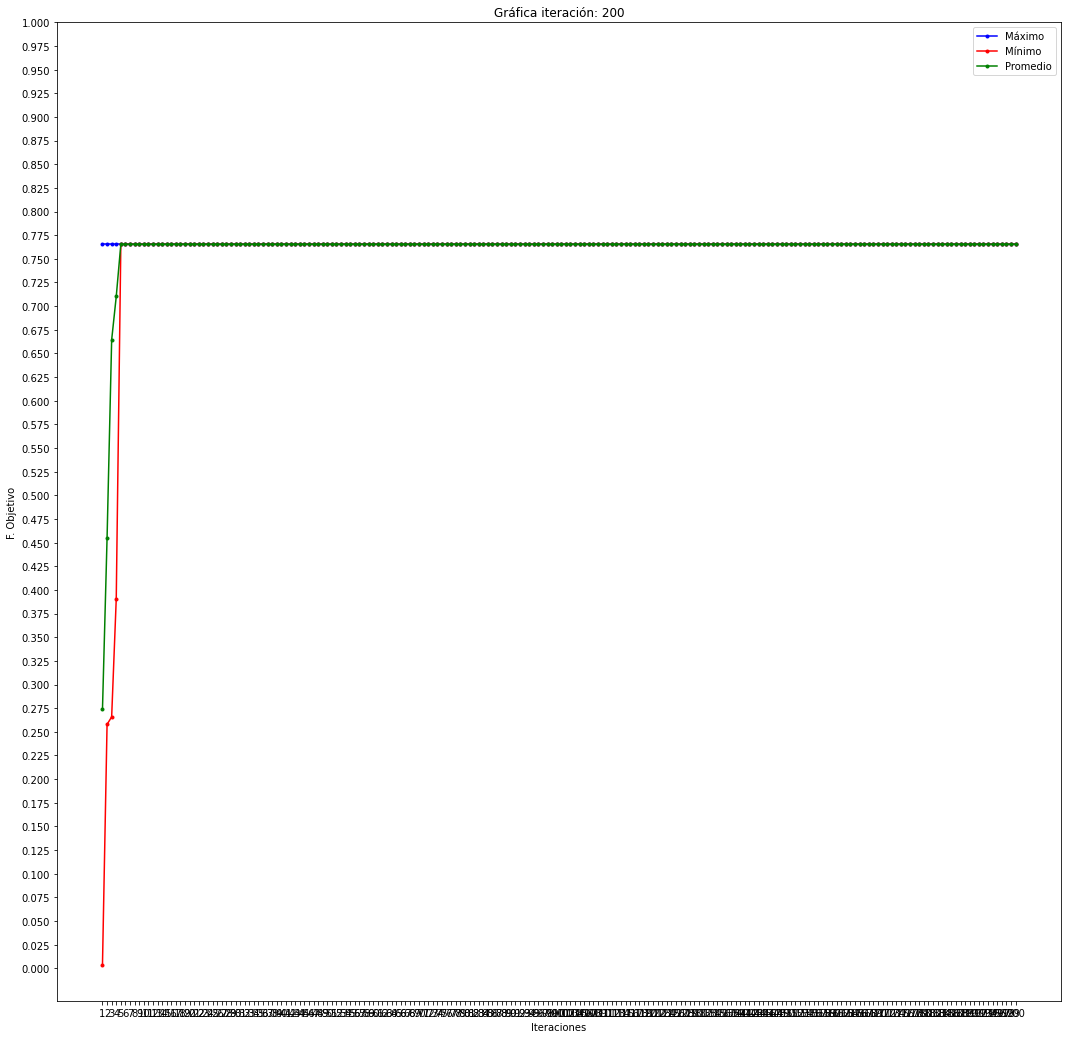

In [75]:
def main(seleccion, ciclos, tieneElitismo = False, mutar = True):
    estadisticas = { "CromosomaMáximo":[],"Máximo":[], "Mínimo":[], "Promedio":[]}
    poblacion_decimal = poblacionInicial()
    poblacion_binarios = convertirPoblacion(poblacion_decimal)
    for i in range(0, ciclos):
        marcoDeDatos = generarDataFrame(poblacion_binarios)
        marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(marcoDeDatos)
        estadisticas["CromosomaMáximo"].append(cromosoma_max)
        estadisticas["Máximo"].append(stats['Máximo'][0])
        estadisticas["Mínimo"].append(stats['Mínimo'][0])
        estadisticas["Promedio"].append(stats['Promedio'][0])
        if tieneElitismo:
            elites = elitismo(poblacion_binarios, 2)
            cromosomasPadres = seleccion(poblacion_binarios, 8)
        else:
            cromosomasPadres = seleccion(poblacion_binarios, 10)
        cromosomasHijos = crossover(cromosomasPadres)
        
        if len(cromosomasHijos)>0:
            if mutar: 
                    cromosomasHijosMutados = mutacion(cromosomasHijos)
                    if tieneElitismo: 
                        poblacion_binarios = cromosomasHijosMutados + elites
                    else:
                        poblacion_binarios = cromosomasHijosMutados
            else:
                if tieneElitismo: 
                    poblacion_binarios = cromosomasHijos + elites
                else:
                    poblacion_binarios = cromosomasHijos

        if ( i == ciclos-1 ):
        #if ( (i==(ITERACIONES_IMPRIMIBLES[0] - 1)) or (i==(ITERACIONES_IMPRIMIBLES[1] - 1)) or (i == (ITERACIONES_IMPRIMIBLES[2] - 1)) ): # 20, 100, 200. le resto 1 xq empieza en 0.
            marcoDeDatos = generarDataFrame(poblacion_binarios)
            marcoDeDatos_stats, stats, cromosoma_max = generarEstadisticas(marcoDeDatos)
            tabla = hacerTabla(i+1, estadisticas["CromosomaMáximo"], estadisticas["Máximo"], estadisticas["Mínimo"], estadisticas["Promedio"])
            # Para guardar tablas
            directory = "tablas"
            if not os.path.exists(directory):
                os.makedirs(directory)
            file = str(counter)+".xlsx"
            tabla.to_excel(os.path.join(directory, file))
            #-----
            tabla = tabla.style.hide(axis='index')
            tabla = tabla.format(precision=10)
            display(tabla)
            hacerGrafico(estadisticas, i+1)


debeMutar = True
conElitismo = True 

casos = { 
    "CASO A: Método selección ruleta": ruleta, 
    "CASO B: Método selección torneo": torneo, 
    "CASO C: Método selección Ruleta con elitismo": (ruleta, conElitismo, debeMutar), 
    "CASO C: Método selección torneo con elitismo": (torneo, conElitismo,debeMutar),

    
    "CASO A: Método selección ruleta sin mutacion": (ruleta, not conElitismo,not debeMutar), 
    "CASO B: Método selección torneo sin mutación": (torneo, not conElitismo,not debeMutar), 
    "CASO C: Método selección Ruleta con elitismo sin mutacion": (ruleta, conElitismo,not debeMutar), 
    "CASO C: Método selección torneo con elitismo sin mutacion": (torneo, conElitismo,not debeMutar) 
}  
 
 
for key, value in casos.items(): 
    print(key) 
    tipo_seleccion,conElitismo, conMutacion = (value[0],value[1],value[2]) if type(value) == tuple else (value,False,True) 
    for ciclo in ITERACIONES_IMPRIMIBLES: 
        main(tipo_seleccion, ciclo,conElitismo,conMutacion)
        counter = counter+1 # para indicar nombre tabla
